# Importing Required Packages & Libraries

In [ ]:
# ------------ Deep Learning & Computer Vision ------------
# Core PyTorch for building and training neural networks
import torch
import torch.nn as nn

# Handling pre-trained models and image transformations
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

# Tools for data loading and batching
from torch.utils.data import Dataset, DataLoader

# High-speed similarity search for dense vectors
import faiss

# ------------ Data Manipulation & Analysis ---------------
# The standard stack for arrays and dataframes
import numpy as np
import pandas as pd

#  ---------- Machine Learning & Statistics (Scikit-Learn)  ---------------
# Clustering algorithms and evaluation metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Dimensionality reduction and visualization
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Classifiers and model selection
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Preprocessing and evaluation performance metrics
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#  ---------- Visualization---------------
# Basic plotting and statistical data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

# ----------- File Handling & System Utilities --- ---------------
# OS interaction, file paths, and directory management
import os
import shutil
from pathlib import Path

# Serialization for saving models and config data
import pickle
import json
import yaml

# Compressed file handling and progress bars
import rarfile
from tqdm.notebook import tqdm

# -- ------------ Environment & General Purpose --- ---------------
# Google Colab specific integration
from google.colab import drive

# Image processing (PIL)
from PIL import Image

# Time tracking and memory management
import time
import gc
from datetime import datetime

# Handling warnings for a cleaner output
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Create project root in Google Drive
PROJECT_ROOT = '/content/drive/MyDrive/image-clustering-retrieval'
os.makedirs(PROJECT_ROOT, exist_ok=True)

# Create folder structure
folders = [
    'data/raw',
    'data/processed',
    'features',
    'models/pretrained',
    'models/clustering',
    'models/classifier',
    'models/faiss_index',
    'results/clustering',
    'results/retrieval/sample_queries',
    'results/classification',
    'configs'
]

for folder in folders:
    os.makedirs(f'{PROJECT_ROOT}/{folder}', exist_ok=True)

print("✅ Project structure created!")
print(f"📁 Project root: {PROJECT_ROOT}")

# Change working directory
os.chdir(PROJECT_ROOT)
print(f"📂 Current directory: {os.getcwd()}")


Mounted at /content/drive
✅ Project structure created!
📁 Project root: /content/drive/MyDrive/image-clustering-retrieval
📂 Current directory: /content/drive/MyDrive/image-clustering-retrieval


# Install Required Packages

In [ ]:
print("📦 Installing required packages...")

!pip install -q torch torchvision
!pip install -q faiss-cpu  # Use faiss-gpu if GPU available
!pip install -q scikit-learn
!pip install -q umap-learn
!pip install -q pillow
!pip install -q matplotlib seaborn
!pip install -q tqdm
!pip install -q pyyaml
!pip install rarfile

print("✅ All packages installed successfully!")


📦 Installing required packages...
✅ All packages installed successfully!


#  Set random seeds

In [ ]:
torch.manual_seed(42)
np.random.seed(42)


# Check GPU

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Using device: {device}")
if device.type == 'cuda':
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

✅ Using device: cuda
   GPU: Tesla T4
   Memory: 15.83 GB


# Extract Caltech-101 Dataset from RAR (Colab Local Storage)

In [ ]:
print("="*60)
print("EXTRACTING CALTECH-101 DATASET FROM RAR (LOCAL COLAB STORAGE)")
print("="*60)

# Install RAR support (only once per runtime)
!apt-get -qq install unrar
!pip install -q rarfile

# Path to uploaded RAR file
uploaded_rar_path = "/content/object.rar"

# Local extraction directory (NOT Google Drive)
extract_dir = "/content"
dataset_path = f"{extract_dir}/object"   # 👈 THIS IS THE KEY FIX

# Check RAR exists
if not os.path.exists(uploaded_rar_path):
    raise FileNotFoundError(
        f"❌ RAR file not found at {uploaded_rar_path}. "
        "Please upload object.rar to Colab."
    )

# Extract only if not already extracted
if not os.path.exists(dataset_path):
    print("📦 Extracting dataset locally in Colab...")

    with rarfile.RarFile(uploaded_rar_path) as rf:
        rf.extractall(extract_dir)

    print("✅ Extraction complete!")
else:
    print("✅ Dataset already extracted — skipping")

# Verify dataset structure
if not os.path.exists(dataset_path):
    raise RuntimeError(
        "❌ Dataset folder 'object/' not found after extraction!"
    )

# Count categories and images
categories = [
    d for d in os.listdir(dataset_path)
    if os.path.isdir(os.path.join(dataset_path, d)) and not d.startswith('.')
]
categories.sort()

total_images = sum(
    len([
        f for f in os.listdir(os.path.join(dataset_path, c))
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ])
    for c in categories
)

print("\n📊 Dataset Statistics:")
print(f"   Total categories: {len(categories)}")
print(f"   Total images: {total_images}")
print(f"\n📁 Dataset location (LOCAL): {dataset_path}")

EXTRACTING CALTECH-101 DATASET FROM RAR (LOCAL COLAB STORAGE)
📦 Extracting dataset locally in Colab...
✅ Extraction complete!

📊 Dataset Statistics:
   Total categories: 45
   Total images: 4269

📁 Dataset location (LOCAL): /content/object


# Create Custom Dataset Class

In [ ]:
class ObjectDataset(Dataset):
    """
    Custom Dataset for Caltech-style object dataset
    Folder structure:
    /content/object/
        ├── accordion/
        ├── airplanes/
        ├── ...
    """

    def __init__(self, root_dir="/content/object", transform=None, max_images_per_class=None):
        self.root_dir = root_dir
        self.transform = transform
        self.max_images_per_class = max_images_per_class

        # Get class folders
        self.categories = sorted([
            d for d in os.listdir(root_dir)
            if os.path.isdir(os.path.join(root_dir, d))
        ])

        self.category_to_idx = {cat: idx for idx, cat in enumerate(self.categories)}

        self.image_paths = []
        self.labels = []

        print(f"📂 Found {len(self.categories)} categories")

        for category in tqdm(self.categories, desc="Scanning categories"):
            cat_path = os.path.join(root_dir, category)
            cat_idx = self.category_to_idx[category]

            images = [
                f for f in os.listdir(cat_path)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ]

            if max_images_per_class:
                images = images[:max_images_per_class]

            for img in images:
                self.image_paths.append(os.path.join(cat_path, img))
                self.labels.append(cat_idx)

        print(f"✅ Loaded {len(self.image_paths)} images")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        try:
            image = Image.open(img_path).convert("RGB")
        except:
            image = Image.new("RGB", (224, 224), color="black")

        if self.transform:
            image = self.transform(image)

        return image, label

    def get_category_name(self, idx):
        return self.categories[idx]


# PHASE 1: DATA PREPARATION"

## Create Dataset and Visualize Samples

------------------------------------------------------------
PHASE 1: DATA PREPARATION
------------------------------------------------------------
📂 Found 45 categories


Scanning categories:   0%|          | 0/45 [00:00<?, ?it/s]

✅ Loaded 4269 images

📊 Dataset created:
   Total images: 4269
   Total categories: 45
✅ Metadata saved

🎨 Visualizing sample images...


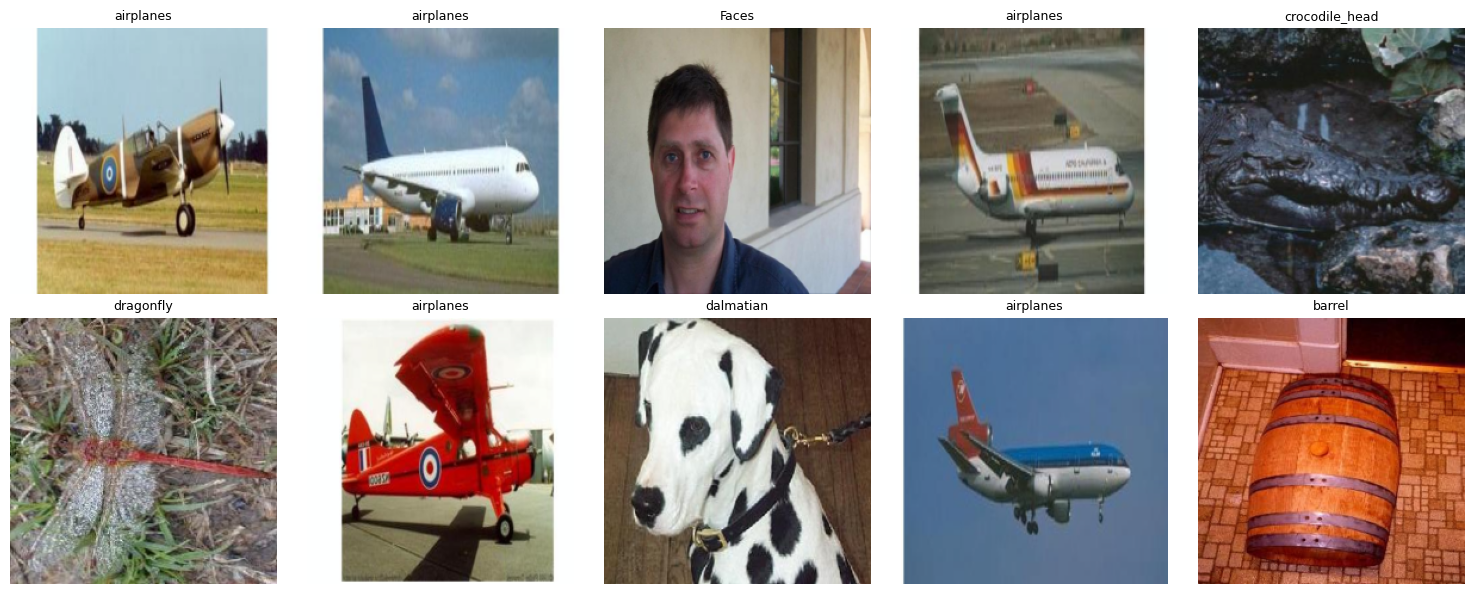

In [ ]:
print("-"*60)
print("PHASE 1: DATA PREPARATION")
print("-"*60)

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# ✅ Use CORRECT dataset class
full_dataset = ObjectDataset(
    root_dir=dataset_path,   # /content/object
    transform=transform,
    max_images_per_class=None
)

print(f"\n📊 Dataset created:")
print(f"   Total images: {len(full_dataset)}")
print(f"   Total categories: {len(full_dataset.categories)}")

# Save metadata
metadata = {
    "num_categories": len(full_dataset.categories),
    "num_images": len(full_dataset),
    "categories": full_dataset.categories,
    "category_to_idx": full_dataset.category_to_idx,
    "dataset_path": dataset_path,
    "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}

os.makedirs(f"{PROJECT_ROOT}/configs", exist_ok=True)

with open(f"{PROJECT_ROOT}/configs/dataset_metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)
print("✅ Metadata saved")

# Visualize samples
def visualize_samples(dataset, num_samples=10):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()

    indices = np.random.choice(len(dataset), num_samples, replace=False)

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    for i, ax in enumerate(axes):
        img, label = dataset[indices[i]]

        img = img.numpy().transpose(1, 2, 0)
        img = std * img + mean
        img = np.clip(img, 0, 1)

        ax.imshow(img)
        ax.set_title(dataset.get_category_name(label), fontsize=9)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

print("\n🎨 Visualizing sample images...")
visualize_samples(full_dataset)

# PHASE 2: FEATURE EXTRACTION

## Feature Extraction with ResNet-50

In [ ]:
print("-"*60)
print("PHASE 2: FEATURE EXTRACTION")
print("-"*60)

class FeatureExtractor:
    def __init__(self, model_name='resnet50', device='cuda'):
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        self.model_name = model_name

        print(f"\n🔧 Loading pretrained {model_name}...")

        if model_name == 'resnet50':
            model = models.resnet50(pretrained=True)
            self.feature_dim = 2048
        else:
            raise ValueError("Only resnet50 supported")

        self.model = nn.Sequential(*list(model.children())[:-1])
        self.model.to(self.device)
        self.model.eval()

        print(f"✅ Model loaded on {self.device}")
        print(f"   Feature dimension: {self.feature_dim}")

    def extract_features(self, dataloader, desc="Extracting features"):
        features_list = []
        labels_list = []

        with torch.no_grad():
            for images, labels in tqdm(dataloader, desc=desc):
                images = images.to(self.device)

                features = self.model(images)
                features = features.view(features.size(0), -1)

                features_list.append(features.cpu().numpy())
                labels_list.append(labels.numpy())

        features = np.vstack(features_list)
        labels = np.concatenate(labels_list)

        return features, labels
# Dataloader
batch_size = 64
dataloader = DataLoader(
    full_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# Feature extractor
extractor = FeatureExtractor(model_name='resnet50', device=device)

print(f"\n📊 Extracting features from {len(full_dataset)} images...")

features, labels = extractor.extract_features(dataloader)

# Normalize
features_normalized = normalize(features, norm='l2')

# Save
os.makedirs(f"{PROJECT_ROOT}/features", exist_ok=True)

np.save(f"{PROJECT_ROOT}/features/embeddings.npy", features_normalized)
np.save(f"{PROJECT_ROOT}/features/labels.npy", labels)
print("✅ Feature extraction & saving complete!")

------------------------------------------------------------
PHASE 2: FEATURE EXTRACTION
------------------------------------------------------------

🔧 Loading pretrained resnet50...
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 73.4MB/s]


✅ Model loaded on cuda
   Feature dimension: 2048

📊 Extracting features from 4269 images...


Extracting features:   0%|          | 0/67 [00:00<?, ?it/s]

✅ Feature extraction & saving complete!


# PHASE 3: CLUSTERING ANALYSIS
## Find Optimal K using Elbow Method

------------------------------------------------------------
PHASE 3: CLUSTERING ANALYSIS
------------------------------------------------------------

🔍 Finding optimal K (testing K=10 to 100)...


Testing K values:   0%|          | 0/10 [00:00<?, ?it/s]

  K= 10: Inertia=1260.44, Silhouette=0.1733
  K= 20: Inertia=1110.38, Silhouette=0.1041
  K= 30: Inertia=1009.43, Silhouette=0.1230
  K= 40: Inertia=943.52, Silhouette=0.1185
  K= 50: Inertia=900.79, Silhouette=0.1241
  K= 60: Inertia=871.11, Silhouette=0.1146
  K= 70: Inertia=852.84, Silhouette=0.1057
  K= 80: Inertia=836.98, Silhouette=0.1019
  K= 90: Inertia=825.27, Silhouette=0.0902
  K=100: Inertia=814.13, Silhouette=0.0876


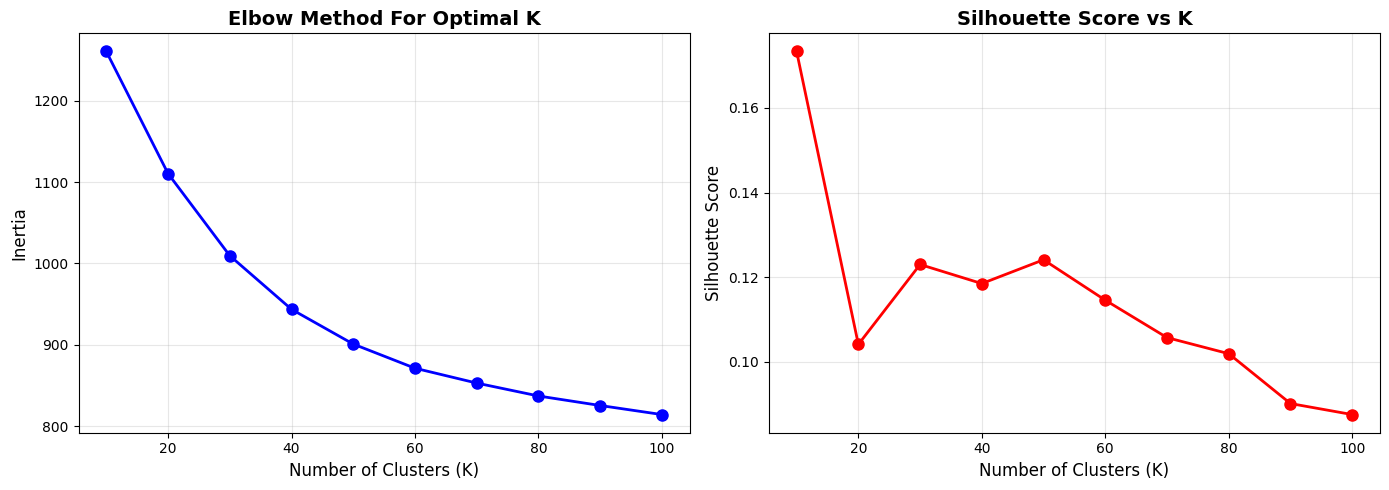


✅ Recommended K: 10 (highest silhouette score)


In [ ]:
print("-"*60)
print("PHASE 3: CLUSTERING ANALYSIS")
print("-"*60)

def find_optimal_k(features, k_range=(10, 100), step=10, sample_size=5000):
    """Find optimal K using elbow method"""
    # Sample for faster computation
    if len(features) > sample_size:
        indices = np.random.choice(len(features), sample_size, replace=False)
        features_sample = features[indices]
    else:
        features_sample = features

    k_values = list(range(k_range[0], k_range[1] + 1, step))
    inertias = []
    silhouette_scores_list = []

    print(f"\n🔍 Finding optimal K (testing K={k_range[0]} to {k_range[1]})...")

    for k in tqdm(k_values, desc="Testing K values"):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels_pred = kmeans.fit_predict(features_sample)
        inertias.append(kmeans.inertia_)

        # Calculate silhouette score on smaller sample
        sample_for_sil = min(3000, len(features_sample))
        sil_indices = np.random.choice(len(features_sample), sample_for_sil, replace=False)
        sil_score = silhouette_score(features_sample[sil_indices], labels_pred[sil_indices])
        silhouette_scores_list.append(sil_score)

        print(f"  K={k:3d}: Inertia={kmeans.inertia_:.2f}, Silhouette={sil_score:.4f}")

    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    ax1.plot(k_values, inertias, 'bo-', linewidth=2, markersize=8)
    ax1.set_xlabel('Number of Clusters (K)', fontsize=12)
    ax1.set_ylabel('Inertia', fontsize=12)
    ax1.set_title('Elbow Method For Optimal K', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)

    ax2.plot(k_values, silhouette_scores_list, 'ro-', linewidth=2, markersize=8)
    ax2.set_xlabel('Number of Clusters (K)', fontsize=12)
    ax2.set_ylabel('Silhouette Score', fontsize=12)
    ax2.set_title('Silhouette Score vs K', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{PROJECT_ROOT}/results/clustering/elbow_curve.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Find optimal K
    optimal_k = k_values[np.argmax(silhouette_scores_list)]
    print(f"\n✅ Recommended K: {optimal_k} (highest silhouette score)")

    return k_values, inertias, silhouette_scores_list, optimal_k

# Find optimal K using all features
k_vals, inertias, sil_scores, optimal_k = find_optimal_k(
    features_normalized,
    k_range=(10, 100),
    step=10,
    sample_size=5000)

# Perform K-Means Clustering

In [ ]:
def perform_kmeans(features, n_clusters, save_path):
    """Perform K-Means clustering"""
    print(f"\n🔧 Training K-Means with K={n_clusters}...")
    kmeans = KMeans(n_clusters=n_clusters,random_state=42,n_init=10,max_iter=300,verbose=1)
    cluster_labels = kmeans.fit_predict(features)

    # Evaluate
    print("\n📊 Evaluating clustering quality...")
    sample_size = min(10000, len(features))
    indices = np.random.choice(len(features), sample_size, replace=False)

    sil_score = silhouette_score(features[indices], cluster_labels[indices])
    db_score = davies_bouldin_score(features, cluster_labels)

    print(f"\n{'-'*60}")
    print("CLUSTERING METRICS")
    print(f"{'-'*60}")
    print(f"Silhouette Score:     {sil_score:.4f}  (higher is better)")
    print(f"Davies-Bouldin Index: {db_score:.4f}  (lower is better)")
    print(f"{'-'*60}")

    # Cluster statistics
    unique, counts = np.unique(cluster_labels, return_counts=True)
    print("\n📈 Cluster Distribution:")
    for cluster_id, count in zip(unique[:10], counts[:10]):
        print(f"  Cluster {cluster_id:3d}: {count:5d} images ({count/len(cluster_labels)*100:.1f}%)")
    if len(unique) > 10:
        print(f"  ... and {len(unique)-10} more clusters")

    # Save model
    with open(f'{save_path}/kmeans_k{n_clusters}.pkl', 'wb') as f:
        pickle.dump(kmeans, f)

    # Save cluster labels
    np.save(f'{save_path}/cluster_labels.npy', cluster_labels)

    # Save metrics
    metrics = {
        'n_clusters': n_clusters,
        'silhouette_score': float(sil_score),
        'davies_bouldin_score': float(db_score),
        'cluster_sizes': {int(k): int(v) for k, v in zip(unique, counts)},
        'created_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }

    with open(f'{save_path}/clustering_metrics.json', 'w') as f:
        json.dump(metrics, f, indent=2)

    print(f"\n✅ K-Means model saved to {save_path}")

    return kmeans, cluster_labels, metrics

# Run clustering on all features
n_clusters = optimal_k
kmeans_model, cluster_labels, clustering_metrics = perform_kmeans(
    features_normalized,
    n_clusters=n_clusters,
    save_path=f'{PROJECT_ROOT}/models/clustering'
)


🔧 Training K-Means with K=10...
Initialization complete
Iteration 0, inertia 2225.45947265625.
Iteration 1, inertia 1300.902099609375.
Iteration 2, inertia 1284.36572265625.
Iteration 3, inertia 1280.91650390625.
Iteration 4, inertia 1279.3536376953125.
Iteration 5, inertia 1278.0694580078125.
Iteration 6, inertia 1276.828857421875.
Iteration 7, inertia 1275.91259765625.
Iteration 8, inertia 1275.46044921875.
Iteration 9, inertia 1275.19677734375.
Iteration 10, inertia 1274.9180908203125.
Iteration 11, inertia 1274.7252197265625.
Iteration 12, inertia 1274.47607421875.
Iteration 13, inertia 1274.276611328125.
Iteration 14, inertia 1273.99755859375.
Iteration 15, inertia 1273.64404296875.
Iteration 16, inertia 1273.31884765625.
Iteration 17, inertia 1272.9432373046875.
Iteration 18, inertia 1272.3173828125.
Iteration 19, inertia 1271.520263671875.
Iteration 20, inertia 1270.268798828125.
Iteration 21, inertia 1269.5498046875.
Iteration 22, inertia 1269.2578125.
Iteration 23, inertia 12

# HIERARCHICAL CLUSTERING (WITH K SELECTION)

🔧 Building linkage matrix (method=average)


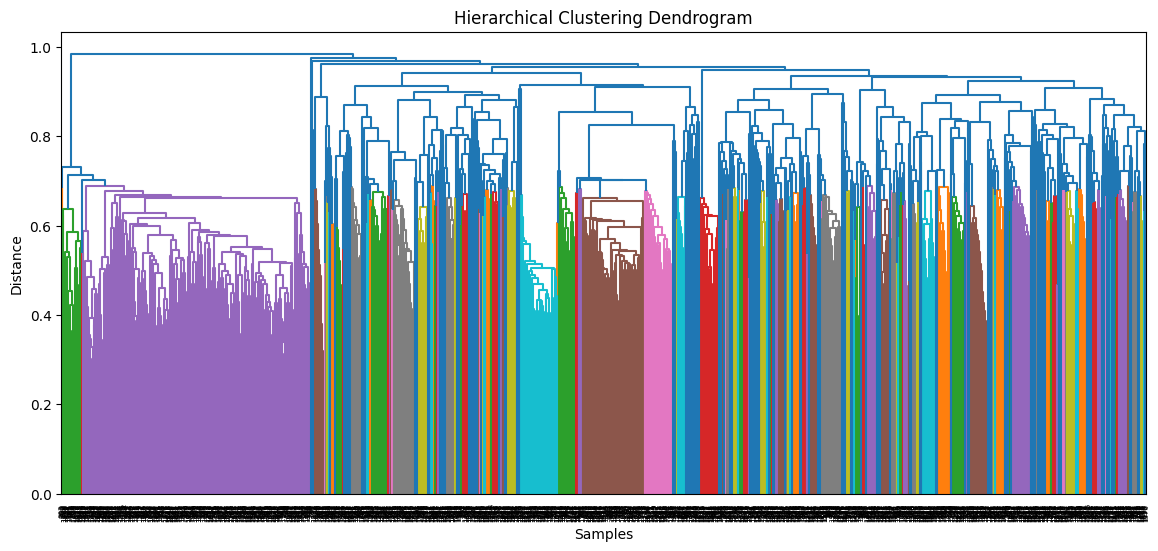

In [ ]:
# --------------------------
# STEP 1: Sample Features (Optional)
# --------------------------
def sample_features(features, sample_size=2000, random_state=42):
    if len(features) > sample_size:
        np.random.seed(random_state)
        indices = np.random.choice(len(features), sample_size, replace=False)
        return features[indices], indices
    return features, np.arange(len(features))

# --------------------------
# STEP 2: Build Linkage Matrix
# --------------------------
def build_linkage_matrix(features, method='average'):
    print(f"🔧 Building linkage matrix (method={method})")
    Z = linkage(features, method=method)
    return Z

# --------------------------
# STEP 3: Plot Dendrogram
# --------------------------
def plot_dendrogram(Z, truncate_level=30, max_d=None):
    plt.figure(figsize=(14, 6))
    dendrogram(Z, truncate_mode='level', p=truncate_level)
    if max_d:
        plt.axhline(y=max_d, c='r', linestyle='--')
    plt.title("Hierarchical Clustering Dendrogram")
    plt.xlabel("Samples")
    plt.ylabel("Distance")
    plt.show()

# --------------------------
# STEP 4: Run Dendrogram Analysis
# --------------------------
# Sample features for efficiency
features_sampled, sample_indices = sample_features(features_normalized, sample_size=2000)

# Build linkage
Z = build_linkage_matrix(features_sampled, method='average')

# Plot dendrogram
plot_dendrogram(Z, truncate_level=30)

# Perform Hierarchical Clustering

In [ ]:
# --------------------------
# STEP 1: Train Hierarchical Clustering with Exact K
# --------------------------
def train_hierarchical_exact_k(features, k=50, linkage_type='average'):
    """
    Train AgglomerativeClustering to produce exactly K clusters
    """
    model = AgglomerativeClustering(
        n_clusters=k,       # Force exact K clusters
        linkage=linkage_type
    )
    labels = model.fit_predict(features)

    sil = silhouette_score(features, labels)
    db = davies_bouldin_score(features, labels)

    print("\nFINAL HIERARCHICAL RESULTS")
    print("-" * 50)
    print(f"Linkage:    {linkage_type}")
    print(f"K:          {k}")
    print(f"Silhouette: {sil:.4f}")
    print(f"DB Index:   {db:.4f}")
    print("-" * 50)

    return model, labels, sil, db

# --------------------------
# STEP 2: Full HIR Pipeline
# --------------------------
def perform_hir_pipeline(features, k=50, linkage_type='average', sample_size=5000, save_path=None):
    # 1️⃣ Sample features if needed
    if len(features) > sample_size:
        indices = np.random.choice(len(features), sample_size, replace=False)
        features_used = features[indices]
        print(f"Using {len(features_used)}/{len(features)} samples")
    else:
        features_used = features

    # 2️⃣ Train hierarchical clustering
    model, cluster_labels, sil, db = train_hierarchical_exact_k(features_used, k=k, linkage_type=linkage_type)

    # 3️⃣ Save model, labels, and metrics
    if save_path:
        os.makedirs(save_path, exist_ok=True)
        with open(f'{save_path}/hir_model_k{k}.pkl', 'wb') as f:
            pickle.dump(model, f)
        np.save(f'{save_path}/hir_labels_k{k}.npy', cluster_labels)
        metrics = {
            'k': k,
            'linkage': linkage_type,
            'silhouette_score': float(sil),
            'davies_bouldin_score': float(db),
            'cluster_sizes': {int(c): int(np.sum(cluster_labels==c)) for c in np.unique(cluster_labels)},
            'sample_size': len(features_used),
            'created_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        }
        with open(f'{save_path}/hir_metrics_k{k}.json', 'w') as f:
            json.dump(metrics, f, indent=2)
        print(f"\n✅ HIR model, labels, and metrics saved to {save_path}")

    return model, cluster_labels, sil, db

# --------------------------
# STEP 3: Run HIR
# --------------------------
hir_model, hir_labels, sil_score, db_score = perform_hir_pipeline(
    features_normalized,
    k=50,
    linkage_type='average',
    sample_size=5000,
    save_path=f'{PROJECT_ROOT}/models/clustering'
)

# Check clusters
print("Unique cluster IDs:", np.unique(hir_labels))
print("Number of clusters:", len(np.unique(hir_labels)))


FINAL HIERARCHICAL RESULTS
--------------------------------------------------
Linkage:    average
K:          50
Silhouette: 0.1981
DB Index:   2.1370
--------------------------------------------------

✅ HIR model, labels, and metrics saved to /content/drive/MyDrive/image-clustering-retrieval/models/clustering
Unique cluster IDs: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Number of clusters: 50


# Visualize Clusters with t-SNE


🎨 Creating t-SNE visualization...
  Computing t-SNE (this may take a few minutes)...


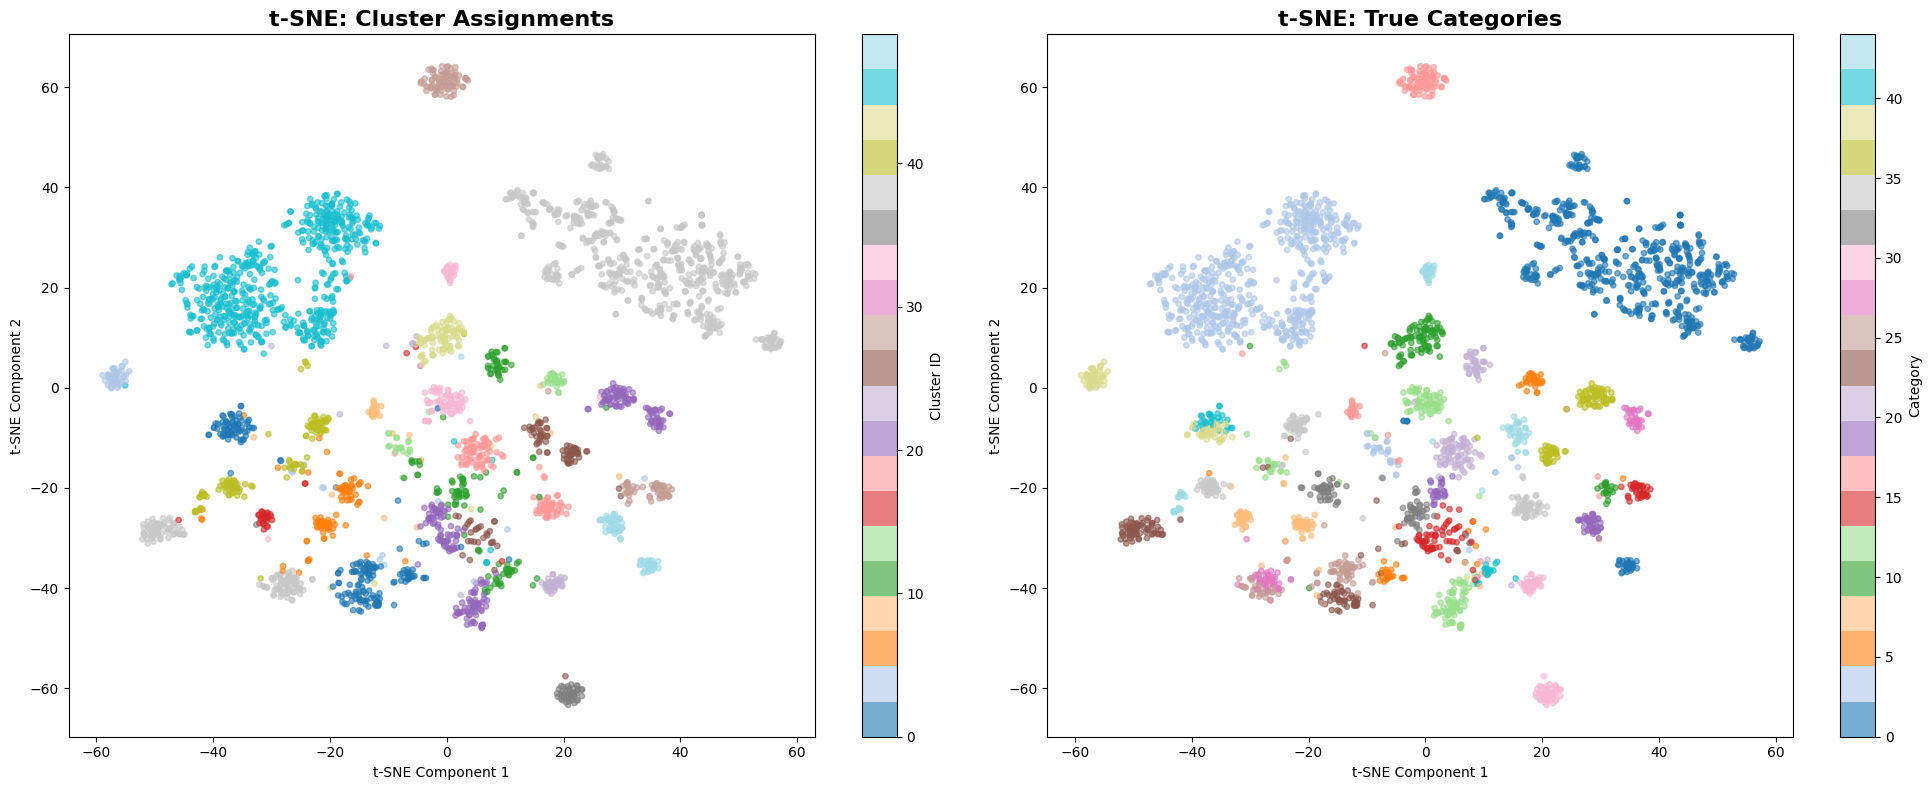

✅ t-SNE visualization complete!


In [ ]:
def visualize_tsne(features, labels, cluster_labels, categories=None, sample_size=3000, save_path=None):
    """
    Create t-SNE visualization for hierarchical clusters and true categories side by side.

    Args:
        features (np.array): CNN embeddings (n_samples, n_features)
        labels (np.array): True labels/categories
        cluster_labels (np.array): Cluster labels from Hierarchical/KMeans
        categories (list or dict): Optional mapping of label indices to category names
        sample_size (int): Max samples to speed up t-SNE
        save_path (str): Path to save the figure
    """
    print("\n🎨 Creating t-SNE visualization...")

    # ---- Sampling ----
    n_samples = min(sample_size, len(features))
    indices = np.random.choice(len(features), n_samples, replace=False)
    features_sample = features[indices]
    labels_sample = labels[indices]
    cluster_sample = cluster_labels[indices]

    # ---- t-SNE projection ----
    print("  Computing t-SNE (this may take a few minutes)...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000, init='pca', learning_rate='auto')
    features_2d = tsne.fit_transform(features_sample)

    # ---- Plotting ----
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Cluster assignments
    scatter1 = ax1.scatter(
        features_2d[:, 0], features_2d[:, 1],
        c=cluster_sample, cmap='tab20', alpha=0.6, s=15
    )
    ax1.set_title('t-SNE: Cluster Assignments', fontsize=16, fontweight='bold')
    ax1.set_xlabel('t-SNE Component 1')
    ax1.set_ylabel('t-SNE Component 2')
    plt.colorbar(scatter1, ax=ax1, label='Cluster ID')

    # True categories
    scatter2 = ax2.scatter(
        features_2d[:, 0], features_2d[:, 1],
        c=labels_sample, cmap='tab20', alpha=0.6, s=15
    )
    ax2.set_title('t-SNE: True Categories', fontsize=16, fontweight='bold')
    ax2.set_xlabel('t-SNE Component 1')
    ax2.set_ylabel('t-SNE Component 2')
    plt.colorbar(scatter2, ax=ax2, label='Category')

    plt.tight_layout()

    # ---- Save figure ----
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')

    plt.show()
    print("✅ t-SNE visualization complete!")

# ===============================
# USAGE EXAMPLE
# ===============================
visualize_tsne(
    features=features_normalized,
    labels=labels,                # True labels of dataset
    cluster_labels=hir_labels,   # Hierarchical cluster labels
    categories=None,              # Optional: list of category names
    sample_size=3000,
    save_path=f'{PROJECT_ROOT}/results/clustering/tsne_plot.png'
)


# Analyze Cluster Composition


📊 Analyzing HIR cluster composition...

Cluster 0 (109 images, entropy=1.10):
  • flamingo: 64 (58.7%)
  • flamingo_head: 43 (39.4%)
  • buddha: 1 (0.9%)
  • brontosaurus: 1 (0.9%)


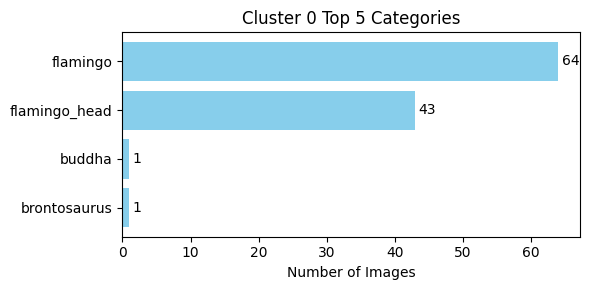


Cluster 1 (173 images, entropy=1.76):
  • crab: 69 (39.9%)
  • crayfish: 63 (36.4%)
  • ant: 35 (20.2%)
  • bass: 2 (1.2%)
  • dragonfly: 2 (1.2%)


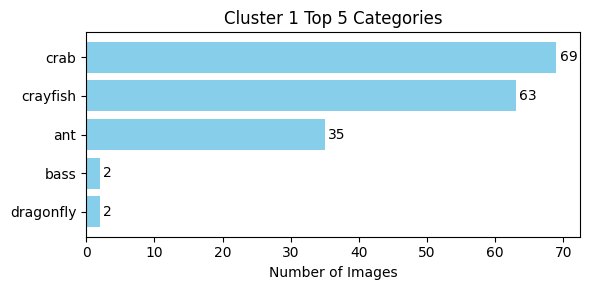


Cluster 2 (7 images, entropy=2.24):
  • brontosaurus: 2 (28.6%)
  • butterfly: 2 (28.6%)
  • electric_guitar: 1 (14.3%)
  • chair: 1 (14.3%)
  • crab: 1 (14.3%)


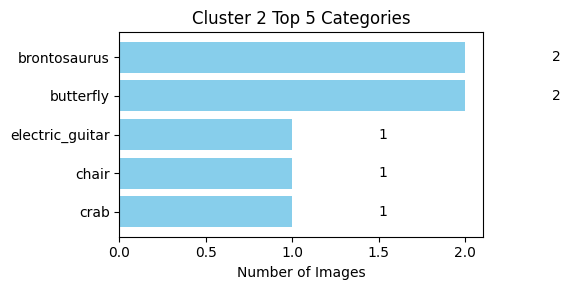


Cluster 3 (17 images, entropy=3.22):
  • brontosaurus: 3 (17.6%)
  • elephant: 2 (11.8%)
  • barrel: 2 (11.8%)
  • dolphin: 2 (11.8%)
  • cannon: 2 (11.8%)


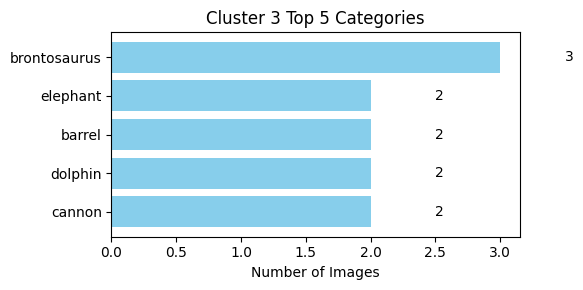


Cluster 4 (66 images, entropy=-0.00):
  • ferry: 66 (100.0%)


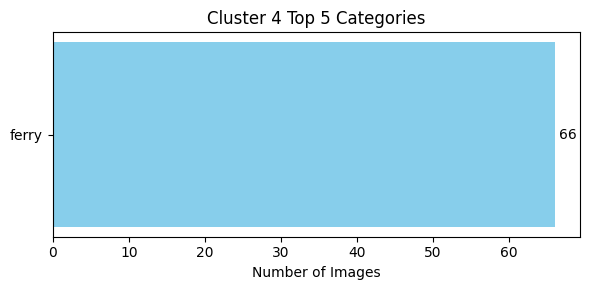


Cluster 5 (10 images, entropy=2.85):
  • gerenuk: 3 (30.0%)
  • flamingo_head: 1 (10.0%)
  • elephant: 1 (10.0%)
  • crocodile: 1 (10.0%)
  • cougar_body: 1 (10.0%)


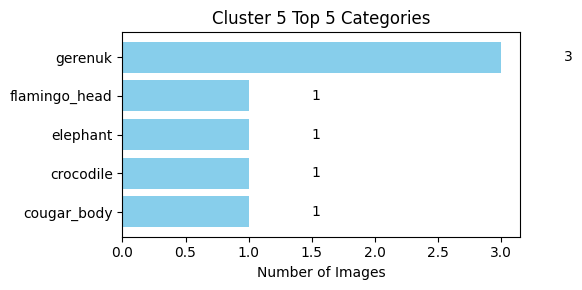


Cluster 6 (119 images, entropy=1.79):
  • dolphin: 61 (51.3%)
  • bass: 42 (35.3%)
  • crocodile: 4 (3.4%)
  • brontosaurus: 3 (2.5%)
  • crocodile_head: 3 (2.5%)


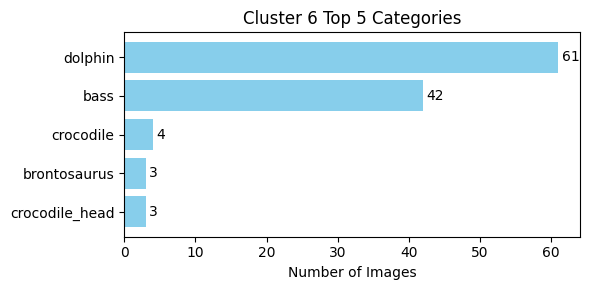


Cluster 7 (2 images, entropy=-0.00):
  • crayfish: 2 (100.0%)


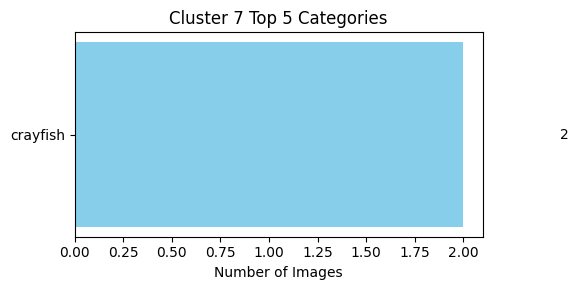


Cluster 8 (4 images, entropy=2.00):
  • flamingo: 1 (25.0%)
  • elephant: 1 (25.0%)
  • dolphin: 1 (25.0%)
  • bass: 1 (25.0%)


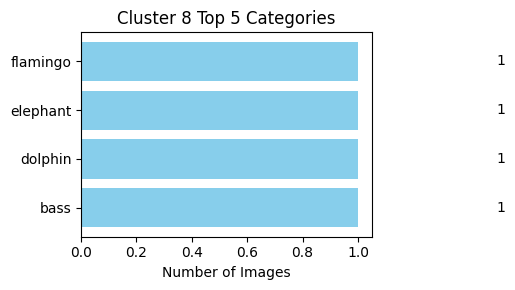


Cluster 9 (39 images, entropy=0.51):
  • cannon: 36 (92.3%)
  • gramophone: 1 (2.6%)
  • brontosaurus: 1 (2.6%)
  • barrel: 1 (2.6%)


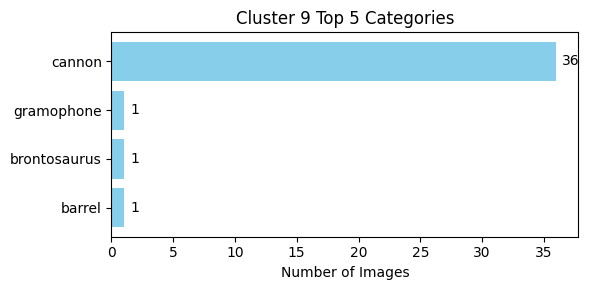


Cluster 10 (76 images, entropy=1.80):
  • ceiling_fan: 44 (57.9%)
  • anchor: 17 (22.4%)
  • dragonfly: 7 (9.2%)
  • chandelier: 3 (3.9%)
  • electric_guitar: 2 (2.6%)


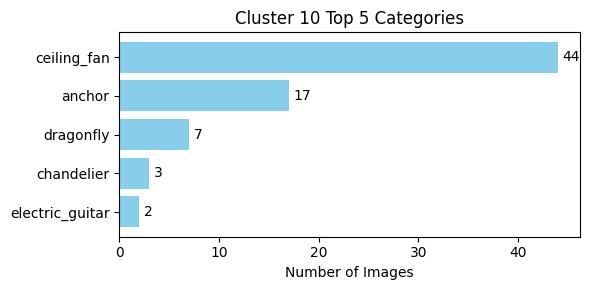


Cluster 11 (64 images, entropy=0.55):
  • chair: 59 (92.2%)
  • chandelier: 2 (3.1%)
  • gramophone: 1 (1.6%)
  • euphonium: 1 (1.6%)
  • ceiling_fan: 1 (1.6%)


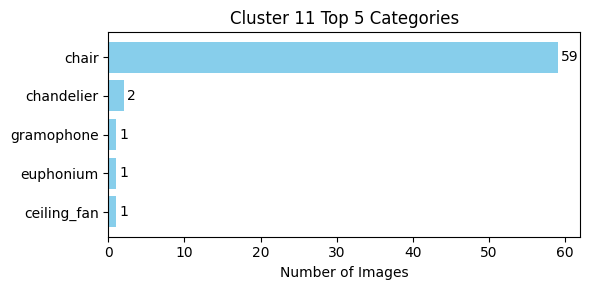


Cluster 12 (65 images, entropy=2.71):
  • garfield: 33 (50.8%)
  • bass: 6 (9.2%)
  • cougar_face: 5 (7.7%)
  • brain: 5 (7.7%)
  • butterfly: 2 (3.1%)


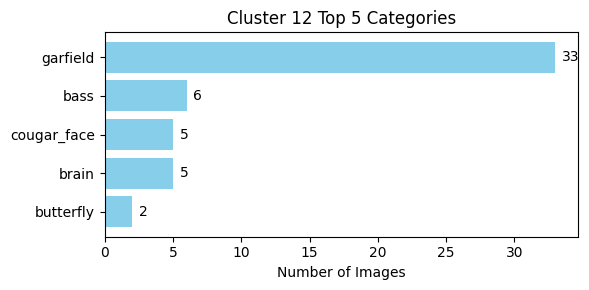


Cluster 13 (42 images, entropy=-0.00):
  • barrel: 42 (100.0%)


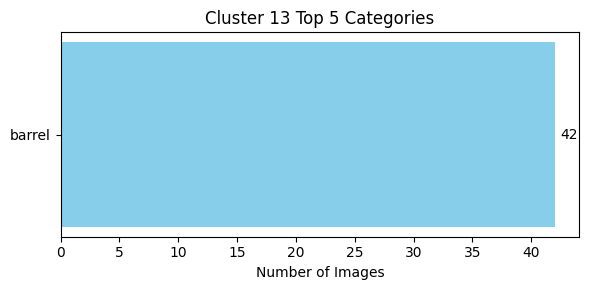


Cluster 14 (25 images, entropy=1.34):
  • anchor: 19 (76.0%)
  • electric_guitar: 2 (8.0%)
  • crayfish: 1 (4.0%)
  • ceiling_fan: 1 (4.0%)
  • buddha: 1 (4.0%)


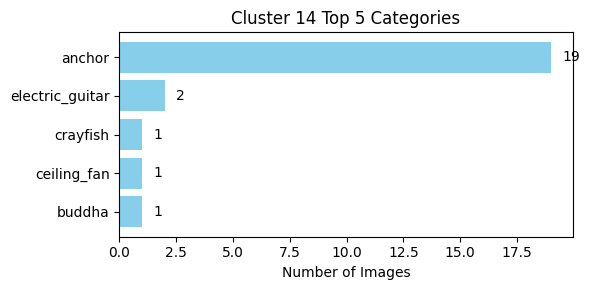


Cluster 15 (2 images, entropy=1.00):
  • crocodile: 1 (50.0%)
  • bonsai: 1 (50.0%)


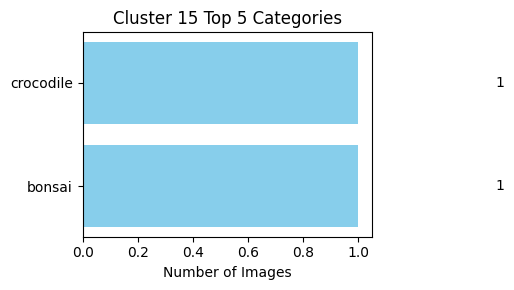


Cluster 16 (3 images, entropy=1.58):
  • crab: 1 (33.3%)
  • cannon: 1 (33.3%)
  • butterfly: 1 (33.3%)


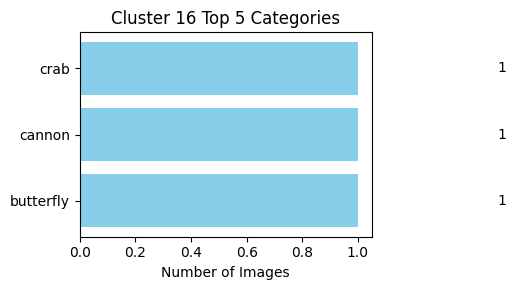


Cluster 17 (43 images, entropy=0.43):
  • beaver: 40 (93.0%)
  • cougar_body: 2 (4.7%)
  • cougar_face: 1 (2.3%)


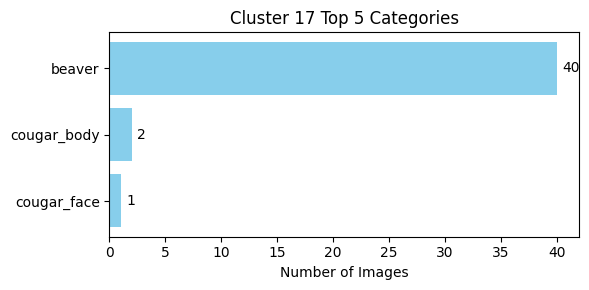


Cluster 18 (71 images, entropy=0.29):
  • electric_guitar: 68 (95.8%)
  • anchor: 2 (2.8%)
  • airplanes: 1 (1.4%)


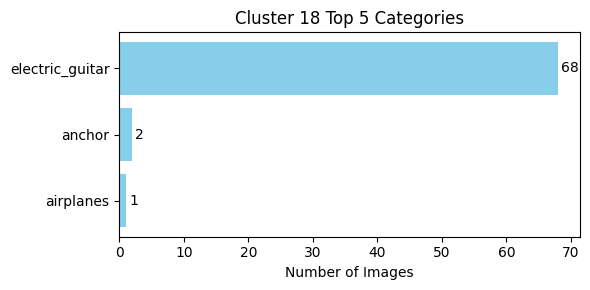


Cluster 19 (101 images, entropy=0.24):
  • chandelier: 98 (97.0%)
  • ewer: 1 (1.0%)
  • electric_guitar: 1 (1.0%)
  • ant: 1 (1.0%)


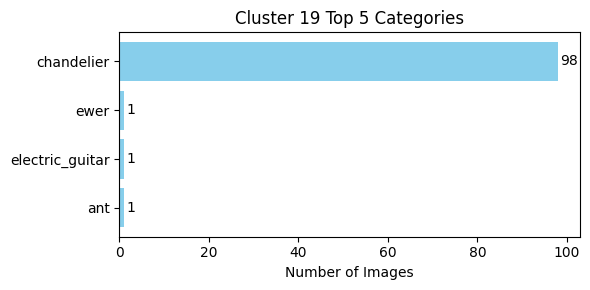


Cluster 20 (99 images, entropy=1.14):
  • butterfly: 49 (49.5%)
  • dragonfly: 48 (48.5%)
  • ceiling_fan: 1 (1.0%)
  • ant: 1 (1.0%)


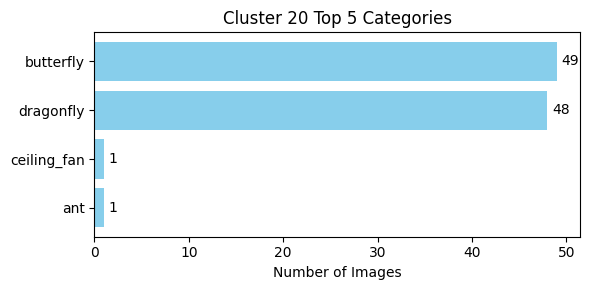


Cluster 21 (134 images, entropy=0.96):
  • ewer: 82 (61.2%)
  • cup: 52 (38.8%)


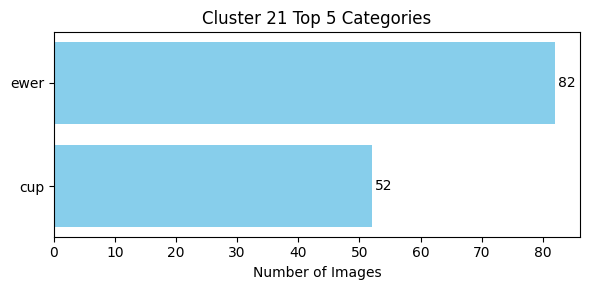


Cluster 22 (92 images, entropy=0.09):
  • brain: 91 (98.9%)
  • butterfly: 1 (1.1%)


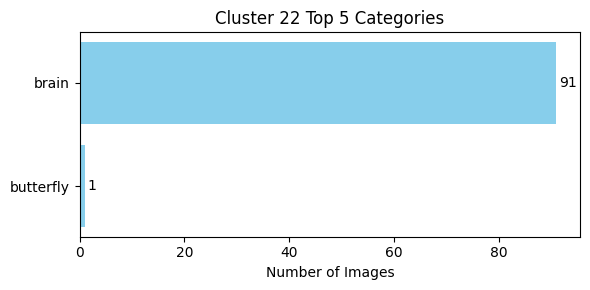


Cluster 23 (6 images, entropy=1.25):
  • bonsai: 4 (66.7%)
  • elephant: 1 (16.7%)
  • butterfly: 1 (16.7%)


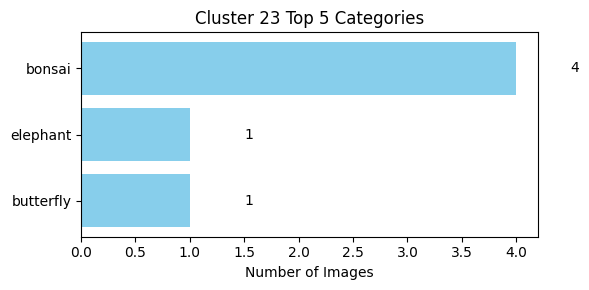


Cluster 24 (54 images, entropy=0.27):
  • dollar_bill: 52 (96.3%)
  • butterfly: 1 (1.9%)
  • brain: 1 (1.9%)


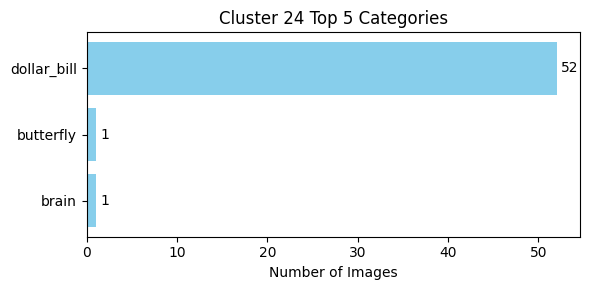


Cluster 25 (115 images, entropy=1.33):
  • euphonium: 63 (54.8%)
  • gramophone: 46 (40.0%)
  • cup: 2 (1.7%)
  • anchor: 2 (1.7%)
  • cannon: 1 (0.9%)


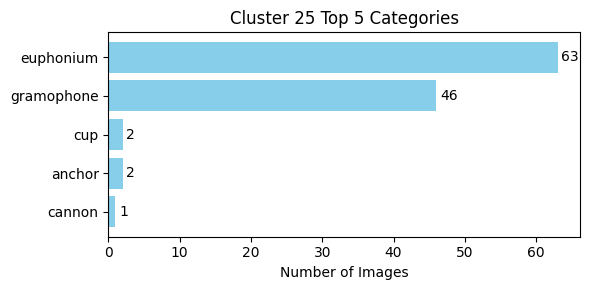


Cluster 26 (43 images, entropy=1.23):
  • butterfly: 30 (69.8%)
  • dragonfly: 9 (20.9%)
  • ant: 3 (7.0%)
  • dalmatian: 1 (2.3%)


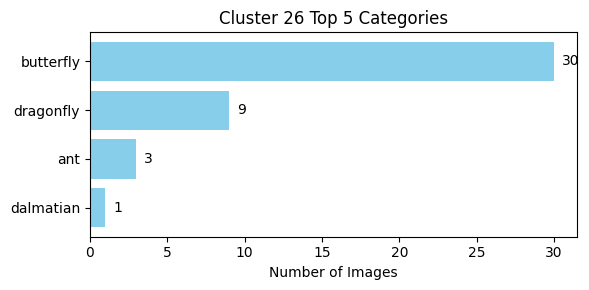


Cluster 27 (1 images, entropy=-0.00):
  • butterfly: 1 (100.0%)


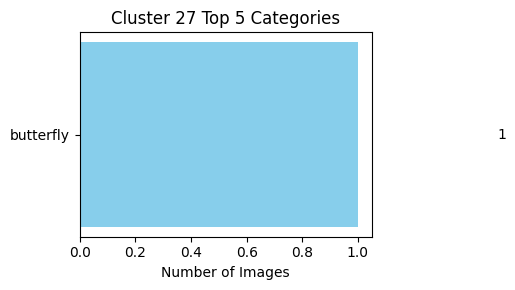


Cluster 28 (84 images, entropy=1.13):
  • camera: 50 (59.5%)
  • binocular: 32 (38.1%)
  • gramophone: 1 (1.2%)
  • barrel: 1 (1.2%)


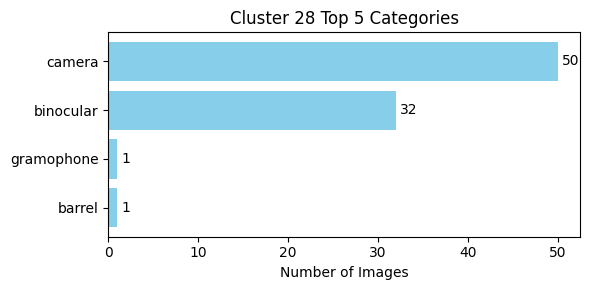


Cluster 29 (123 images, entropy=-0.00):
  • car_side: 123 (100.0%)


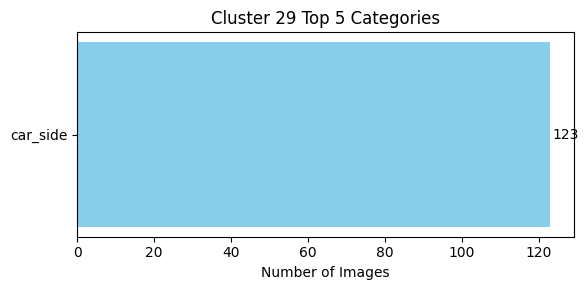


Cluster 30 (1 images, entropy=-0.00):
  • airplanes: 1 (100.0%)


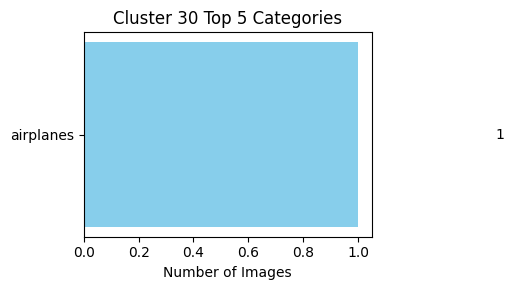


Cluster 31 (1 images, entropy=-0.00):
  • bonsai: 1 (100.0%)


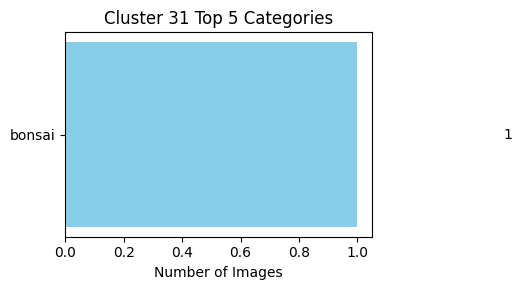


Cluster 32 (89 images, entropy=0.60):
  • buddha: 81 (91.0%)
  • Faces: 3 (3.4%)
  • Faces_easy: 3 (3.4%)
  • ewer: 1 (1.1%)
  • chandelier: 1 (1.1%)


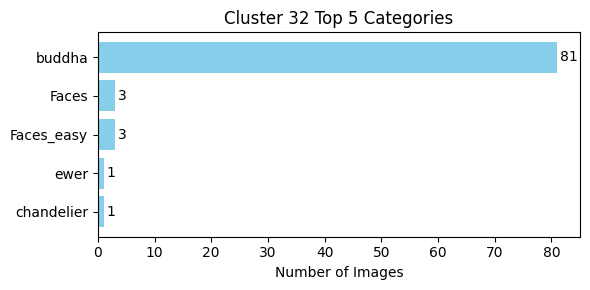


Cluster 33 (1 images, entropy=-0.00):
  • crocodile_head: 1 (100.0%)


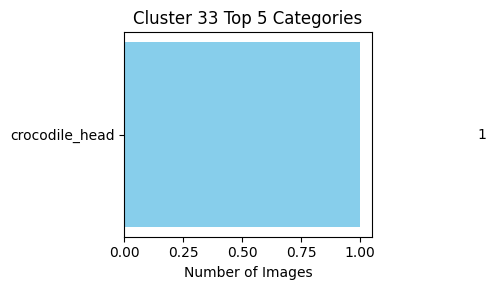


Cluster 34 (35 images, entropy=-0.00):
  • grand_piano: 35 (100.0%)


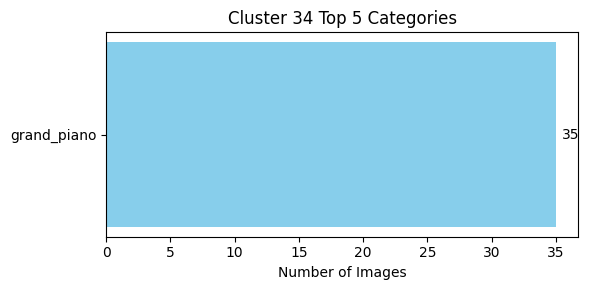


Cluster 35 (66 images, entropy=-0.00):
  • dalmatian: 66 (100.0%)


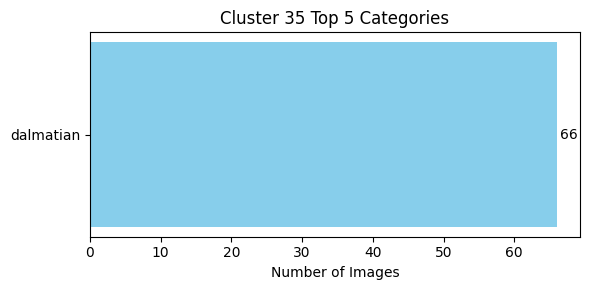


Cluster 36 (2 images, entropy=1.00):
  • dolphin: 1 (50.0%)
  • beaver: 1 (50.0%)


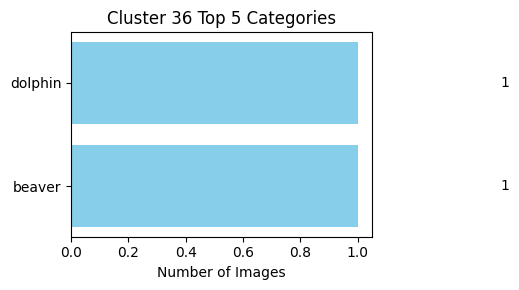


Cluster 37 (103 images, entropy=0.96):
  • cougar_face: 63 (61.2%)
  • cougar_body: 40 (38.8%)


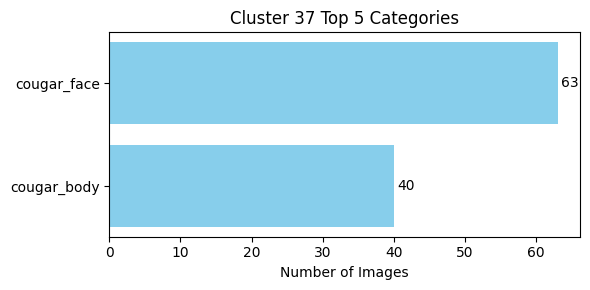


Cluster 38 (90 images, entropy=1.00):
  • crocodile_head: 47 (52.2%)
  • crocodile: 43 (47.8%)


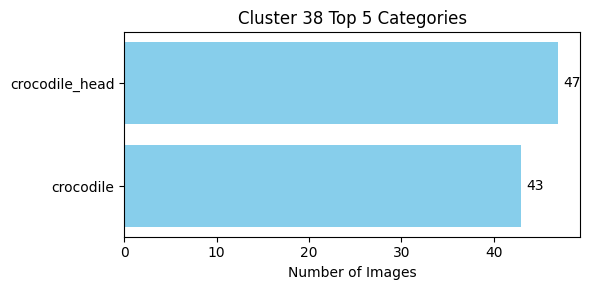


Cluster 39 (862 images, entropy=1.00):
  • Faces_easy: 431 (50.0%)
  • Faces: 431 (50.0%)


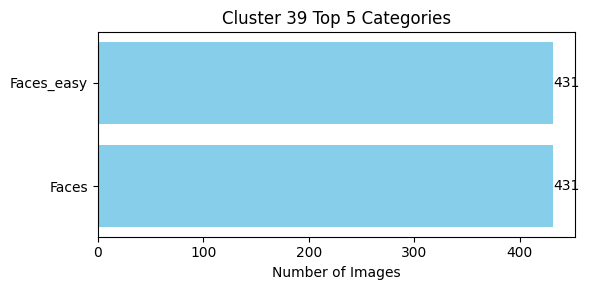


Cluster 40 (87 images, entropy=1.19):
  • emu: 53 (60.9%)
  • gerenuk: 31 (35.6%)
  • cougar_body: 1 (1.1%)
  • brontosaurus: 1 (1.1%)
  • beaver: 1 (1.1%)


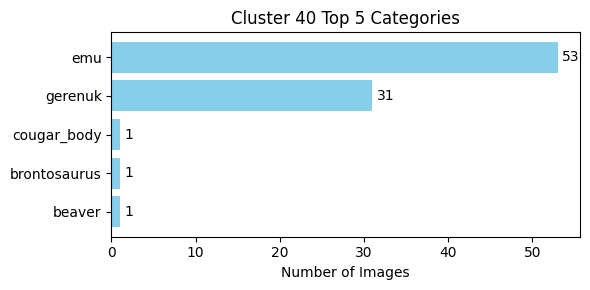


Cluster 41 (94 images, entropy=1.32):
  • elephant: 58 (61.7%)
  • brontosaurus: 30 (31.9%)
  • cougar_body: 3 (3.2%)
  • crocodile: 1 (1.1%)
  • bonsai: 1 (1.1%)


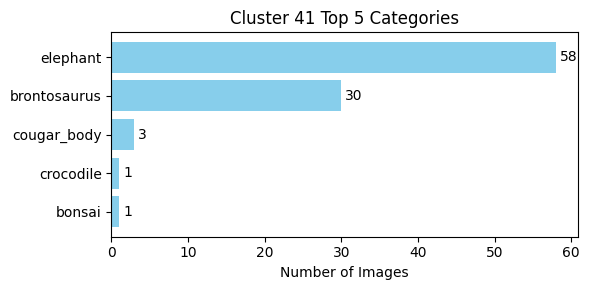


Cluster 42 (117 images, entropy=0.07):
  • bonsai: 116 (99.1%)
  • gramophone: 1 (0.9%)


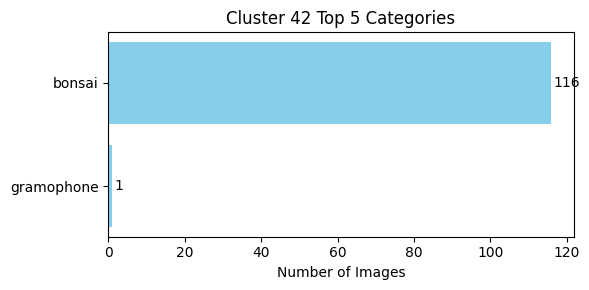


Cluster 43 (2 images, entropy=1.00):
  • garfield: 1 (50.0%)
  • crayfish: 1 (50.0%)


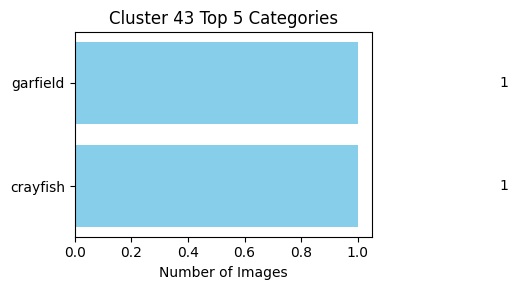


Cluster 44 (2 images, entropy=1.00):
  • chandelier: 1 (50.0%)
  • butterfly: 1 (50.0%)


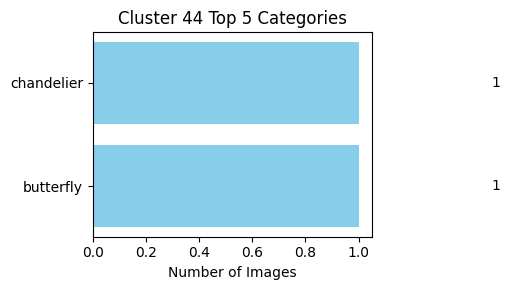


Cluster 45 (800 images, entropy=0.04):
  • airplanes: 797 (99.6%)
  • grand_piano: 1 (0.1%)
  • ferry: 1 (0.1%)
  • cannon: 1 (0.1%)


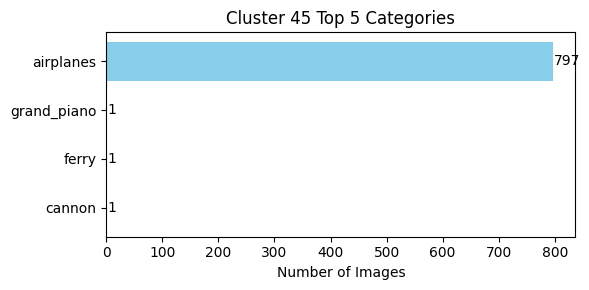


Cluster 46 (7 images, entropy=2.52):
  • chandelier: 2 (28.6%)
  • dragonfly: 1 (14.3%)
  • crab: 1 (14.3%)
  • chair: 1 (14.3%)
  • bass: 1 (14.3%)


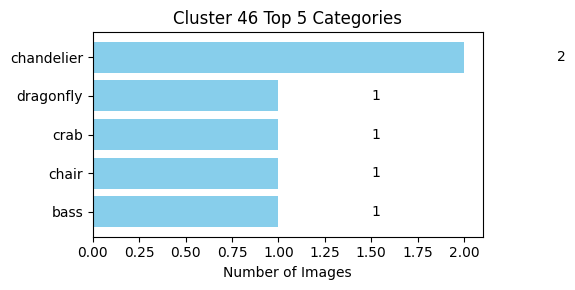


Cluster 47 (1 images, entropy=-0.00):
  • ant: 1 (100.0%)


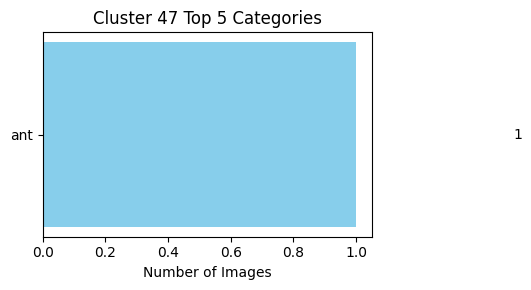


Cluster 48 (4 images, entropy=-0.00):
  • bonsai: 4 (100.0%)


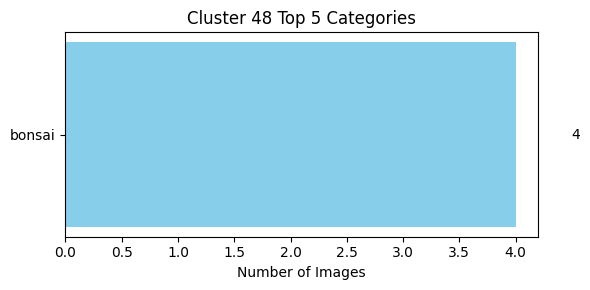


Cluster 49 (116 images, entropy=1.12):
  • cellphone: 59 (50.9%)
  • accordion: 55 (47.4%)
  • cup: 1 (0.9%)
  • bass: 1 (0.9%)


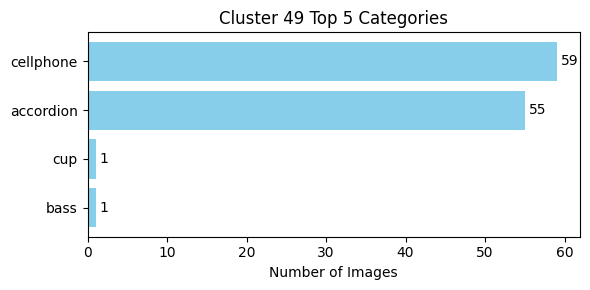

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def analyze_clusters_hir_plot(cluster_labels, true_labels, categories, top_n=50, top_k_per_cluster=5):
    """
    Analyze cluster composition for HIR and plot horizontal bar plots for top categories.

    Args:
        cluster_labels: array-like, cluster assignments
        true_labels: array-like, ground-truth labels
        categories: list of category names
        top_n: maximum number of clusters to analyze
        top_k_per_cluster: top categories to show per cluster

    Returns:
        cluster_info: list of dicts with cluster statistics
    """
    print("\n📊 Analyzing HIR cluster composition...")
    n_clusters = len(np.unique(cluster_labels))
    cluster_info = []

    for cluster_id in range(min(top_n, n_clusters)):
        mask = cluster_labels == cluster_id
        cluster_true_labels = true_labels[mask]
        cluster_size = len(cluster_true_labels)
        if cluster_size == 0:
            continue

        unique, counts = np.unique(cluster_true_labels, return_counts=True)
        sorted_idx = np.argsort(counts)[::-1][:top_k_per_cluster]
        top_categories = [(categories[unique[i]], counts[i], counts[i]/cluster_size*100) for i in sorted_idx]

        # Cluster diversity (Shannon entropy)
        probs = counts / counts.sum()
        entropy = -np.sum(probs * np.log2(probs + 1e-9))

        cluster_info.append({
            'cluster_id': cluster_id,
            'size': cluster_size,
            'top_categories': top_categories,
            'entropy': entropy
        })

        # Print summary
        print(f"\nCluster {cluster_id} ({cluster_size} images, entropy={entropy:.2f}):")
        for cat, count, pct in top_categories:
            print(f"  • {cat}: {count} ({pct:.1f}%)")

        # Horizontal bar plot
        plt.figure(figsize=(6, 3))
        cats = [cat for cat, _, _ in top_categories][::-1]
        counts_plot = [count for _, count, _ in top_categories][::-1]
        plt.barh(cats, counts_plot, color='skyblue')
        plt.xlabel("Number of Images")
        plt.title(f"Cluster {cluster_id} Top {top_k_per_cluster} Categories")
        for i, v in enumerate(counts_plot):
            plt.text(v + 0.5, i, str(v), va='center')
        plt.tight_layout()
        plt.show()

    return cluster_info

# Usage
cluster_analysis_hir = analyze_clusters_hir_plot(
    cluster_labels=hir_labels,
    true_labels=labels,
    categories=full_dataset.categories,
    top_n=50,
    top_k_per_cluster=5
)

# PHASE 4: IMAGE RETRIEVAL SYSTEM

## Build FAISS Index

In [ ]:
print("-"*60)
print("PHASE 3: IMAGE RETRIEVAL SYSTEM")
print("-"*60)

class FAISSRetrieval:
    """FAISS-based similarity search system"""

    def __init__(self, feature_dim):
        self.feature_dim = feature_dim
        self.index = None
        self.image_paths = None
        self.labels = None

    def build_index(self, features, image_paths, labels, index_type='l2'):
        """Build FAISS index"""
        print(f"\n🔧 Building FAISS index...")
        print(f"   Features shape: {features.shape}")
        print(f"   Index type: {index_type}")

        self.image_paths = np.array(image_paths)
        self.labels = np.array(labels)

        features = features.astype("float32")

        if index_type == "l2":
            self.index = faiss.IndexFlatL2(self.feature_dim)
        elif index_type == "cosine":
            faiss.normalize_L2(features)
            self.index = faiss.IndexFlatIP(self.feature_dim)
        else:
            raise ValueError("index_type must be 'l2' or 'cosine'")

        self.index.add(features)

        print(f"✅ FAISS index built with {self.index.ntotal} vectors")
        return self

    def save_index(self, save_path):
        """Save FAISS index"""
        faiss.write_index(self.index, f"{save_path}/image_index.faiss")
        np.save(f"{save_path}/index_paths.npy", self.image_paths)
        np.save(f"{save_path}/index_labels.npy", self.labels)
        print(f"✅ FAISS index saved to {save_path}")

    def load_index(self, load_path):
        """Load FAISS index"""
        self.index = faiss.read_index(f"{load_path}/image_index.faiss")
        self.image_paths = np.load(f"{load_path}/index_paths.npy")
        self.labels = np.load(f"{load_path}/index_labels.npy")
        print(f"✅ FAISS index loaded ({self.index.ntotal} vectors)")

    def search(self, query_feature, k=10):
        """Search top-K similar images"""
        query_feature = query_feature.reshape(1, -1).astype("float32")
        distances, indices = self.index.search(query_feature, k)

        results = []
        for dist, idx in zip(distances[0], indices[0]):
            similarity = 1 / (1 + dist)  # L2 similarity
            results.append({
                "index": int(idx),
                "image_path": self.image_paths[idx],
                "label": int(self.labels[idx]),
                "distance": float(dist),
                "similarity": float(similarity)
            })

        return results


# ===============================
# Build FAISS index
# ===============================

print("\n📊 Building FAISS index for retrieval...")

# BEFORE building FAISS index
image_paths = full_dataset.image_paths
retrieval = FAISSRetrieval(feature_dim=features_normalized.shape[1])
retrieval.build_index(
    features=features_normalized,
    image_paths=image_paths,   # ✅ NOW DEFINED
    labels=labels,
    index_type="l2"
)

retrieval.save_index(f"{PROJECT_ROOT}/models/faiss_index")

print("\n✅ FAISS index created successfully!")
print(f"   Total indexed images: {retrieval.index.ntotal}")


------------------------------------------------------------
PHASE 3: IMAGE RETRIEVAL SYSTEM
------------------------------------------------------------

📊 Building FAISS index for retrieval...

🔧 Building FAISS index...
   Features shape: (4269, 2048)
   Index type: l2
✅ FAISS index built with 4269 vectors
✅ FAISS index saved to /content/drive/MyDrive/image-clustering-retrieval/models/faiss_index

✅ FAISS index created successfully!
   Total indexed images: 4269


In [ ]:
import faiss
import numpy as np
import json
import os
from tqdm import tqdm

# ------------------------------
# CONFIG
# ------------------------------
K_VALUES = [1, 5, 10, 20]          # K for Precision@K

# ------------------------------
# Load features and labels
# ------------------------------
# Assume you already have these numpy arrays
# features: (num_images, feature_dim), labels: (num_images,)
features_path = f"{PROJECT_ROOT}/features/embeddings.npy"
labels_path = f"{PROJECT_ROOT}/features/labels.npy"

features = np.load(features_path)
labels = np.load(labels_path)

# ------------------------------
# Load FAISS index
# ------------------------------
index_path = f"{PROJECT_ROOT}/models/faiss_index/image_index.faiss"
index = faiss.read_index(index_path)

# ------------------------------
# Compute Precision@K
# ------------------------------
precision_at_k = {}

for K in K_VALUES:
    correct_counts = 0
    for i in tqdm(range(len(features)), desc=f"Computing Precision@{K}"):
        query_vec = features[i].reshape(1, -1).astype('float32')
        _, idxs = index.search(query_vec, K+1)  # +1 because the query itself is retrieved
        retrieved_labels = labels[idxs[0][1:]]  # skip the first (self-match)
        if labels[i] in retrieved_labels:
            correct_counts += 1
    precision_at_k[f"precision@{K}"] = correct_counts / len(features)

# ------------------------------
# Save retrieval metrics
# ------------------------------
retrieval_metrics_path = f"{PROJECT_ROOT}/results/retrieval/retrieval_metrics.json"
os.makedirs(os.path.dirname(retrieval_metrics_path), exist_ok=True)
with open(retrieval_metrics_path, 'w') as f:
    json.dump(precision_at_k, f, indent=2)

print("✅ Retrieval metrics (Precision@K) computed and saved!")
print(precision_at_k)


Computing Precision@20: 100%|██████████| 4269/4269 [00:09<00:00, 455.52it/s]


✅ Retrieval metrics (Precision@K) computed and saved!
{'precision@1': 0.8749121574139143, 'precision@5': 0.9854766924338253, 'precision@10': 0.9936753338018272, 'precision@20': 0.9967205434527993}


For each image, it queries the FAISS index to find the top K most similar images.
Then it checks if the query image’s true label appears in those top K results.
It counts how often the correct label is retrieved and divides by total images to get Precision@K.
The final output shows the accuracy of retrieval at different K values (e.g., 1, 5, 10, 20).

# Testing on Unseen Images

In [ ]:
# Step 0: Define transforms (same as used for dataset)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def visualize_unseen_query(img, results, categories):
    """Visualize uploaded query image and retrieval results"""
    fig = plt.figure(figsize=(16, 4))

    # Query image
    ax = plt.subplot(1, len(results)+1, 1)
    ax.imshow(img)
    ax.set_title("Query Image", fontsize=10, fontweight='bold', color='blue')
    ax.axis('off')
    ax.set_facecolor('#e6f2ff')

    # Retrieved images
    for i, res in enumerate(results):
        ax = plt.subplot(1, len(results)+1, i+2)
        retrieved_img = Image.open(res['image_path']).convert("RGB")
        ax.imshow(retrieved_img)

        cat_name = categories[res['label']]
        ax.set_title(f"{cat_name}\nSim: {res['similarity']:.3f}", fontsize=8, color='green')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# ---------- Step 1: Upload unseen image ----------
uploaded = files.upload()  # Upload 1 or more images
uploaded_path = list(uploaded.keys())[0]
img = Image.open(uploaded_path).convert("RGB")

# ---------- Step 2: Extract feature ----------
extractor.model.eval()
with torch.no_grad():
    img_tensor = transform(img).unsqueeze(0).to(extractor.device)
    feature = extractor.model(img_tensor)
    feature = feature.view(feature.size(0), -1).cpu().numpy()
    feature = feature / np.linalg.norm(feature)  # L2 normalize

# ---------- Step 3: Search FAISS ----------
results = retrieval.search(feature, k=9)
# ---------- Step 4: Visualize ----------
visualize_unseen_query(img, results, full_dataset.categories)

# Train Classifier 1 (Random Forest classifier)

In [ ]:
  print("-"*60)
  print("PHASE 4: CLASSIFICATION")
  print("-"*60)

  # --- Step 1: Create train/validation split ---
  X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
      features_normalized,
      labels,
      test_size=0.2,
      random_state=42,
      stratify=labels
  )
  print(f"Train samples: {len(X_train_split)}, Validation samples: {len(X_val_split)}")

  # --- Step 2: Optional PCA ---
  use_pca = True
  if use_pca and X_train_split.shape[1] > 512:
      print("Applying PCA to reduce feature dimensions to 512...")
      pca_model = PCA(n_components=512, random_state=42)
      X_train_proc = pca_model.fit_transform(X_train_split)
      X_val_proc = pca_model.transform(X_val_split)

      # Save PCA
      os.makedirs(f'{PROJECT_ROOT}/models/classifier', exist_ok=True)
      with open(f'{PROJECT_ROOT}/models/classifier/pca.pkl', 'wb') as f:
          pickle.dump(pca_model, f)
  else:
      X_train_proc, X_val_proc = X_train_split, X_val_split
      pca_model = None

  # --- Step 3: Standardize features ---
  scaler_model = StandardScaler()
  X_train_proc = scaler_model.fit_transform(X_train_proc)
  X_val_proc = scaler_model.transform(X_val_proc)

  # Save scaler
  with open(f'{PROJECT_ROOT}/models/classifier/scaler.pkl', 'wb') as f:
      pickle.dump(scaler_model, f)

  # --- Step 4: Train classifier ---
  print("\nTraining Random Forest classifier...")
  classifier = RandomForestClassifier(
      n_estimators=100,
      max_depth=20,
      random_state=42,
      n_jobs=-1,
      verbose=1
  )
  classifier.fit(X_train_proc, y_train_split)

  # Save classifier
  with open(f'{PROJECT_ROOT}/models/classifier/random_forest.pkl', 'wb') as f:
      pickle.dump(classifier, f)

  # --- Step 5: Evaluate ---
  train_pred = classifier.predict(X_train_proc)
  val_pred = classifier.predict(X_val_proc)
  train_acc = accuracy_score(y_train_split, train_pred)
  val_acc = accuracy_score(y_val_split, val_pred)

  print(f"\nTraining Accuracy:   {train_acc:.4f}")
  print(f"Validation Accuracy: {val_acc:.4f}")

  # Save results
  results = {
      'classifier_type': 'random_forest',
      'train_accuracy': float(train_acc),
      'validation_accuracy': float(val_acc),
      'use_pca': use_pca,
      'created_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
  }

  with open(f'{PROJECT_ROOT}/models/classifier/classification_results.json', 'w') as f:
      json.dump(results, f, indent=2)

  print("✅ Classifier trained and saved!")


------------------------------------------------------------
PHASE 4: CLASSIFICATION
------------------------------------------------------------
Train samples: 3415, Validation samples: 854
Applying PCA to reduce feature dimensions to 512...

Training Random Forest classifier...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished



Training Accuracy:   1.0000
Validation Accuracy: 0.9133
✅ Classifier trained and saved!


#  Train Classifier 2 (SVM classifier)

In [ ]:
print("-"*60)
print("PHASE 4: CLASSIFICATION (SVM)")
print("-"*60)

# --- Step 1: Train SVM ---
print("\nTraining SVM (RBF kernel)...")

svm_classifier = SVC(
    kernel='rbf',
    C=10,                  # strong but not crazy
    gamma='scale',         # adaptive, safe default
    probability=False,     # faster, you don't need probs
    class_weight='balanced',  # IMPORTANT for Caltech-101
    verbose=True
)

svm_classifier.fit(X_train_proc, y_train_split)

# --- Step 2: Evaluate ---
train_pred_svm = svm_classifier.predict(X_train_proc)
val_pred_svm = svm_classifier.predict(X_val_proc)

train_acc_svm = accuracy_score(y_train_split, train_pred_svm)
val_acc_svm = accuracy_score(y_val_split, val_pred_svm)

print(f"\nSVM Training Accuracy:   {train_acc_svm:.4f}")
print(f"SVM Validation Accuracy: {val_acc_svm:.4f}")

# --- Step 3: Save model ---
os.makedirs(f'{PROJECT_ROOT}/models/classifier', exist_ok=True)

with open(f'{PROJECT_ROOT}/models/classifier/svm_rbf.pkl', 'wb') as f:
    pickle.dump(svm_classifier, f)

# --- Step 4: Save results ---
svm_results = {
    'classifier_type': 'svm_rbf',
    'kernel': 'rbf',
    'C': 10,
    'gamma': 'scale',
    'train_accuracy': float(train_acc_svm),
    'validation_accuracy': float(val_acc_svm),
    'use_pca': True,
    'created_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open(f'{PROJECT_ROOT}/models/classifier/classification_results_svm.json', 'w') as f:
    json.dump(svm_results, f, indent=2)

print("✅ SVM classifier trained and saved!")

------------------------------------------------------------
PHASE 4: CLASSIFICATION (SVM)
------------------------------------------------------------

Training SVM (RBF kernel)...
[LibSVM]
SVM Training Accuracy:   0.9991
SVM Validation Accuracy: 0.9192
✅ SVM classifier trained and saved!


# SVM vs RF Accuracy Comparison Plot

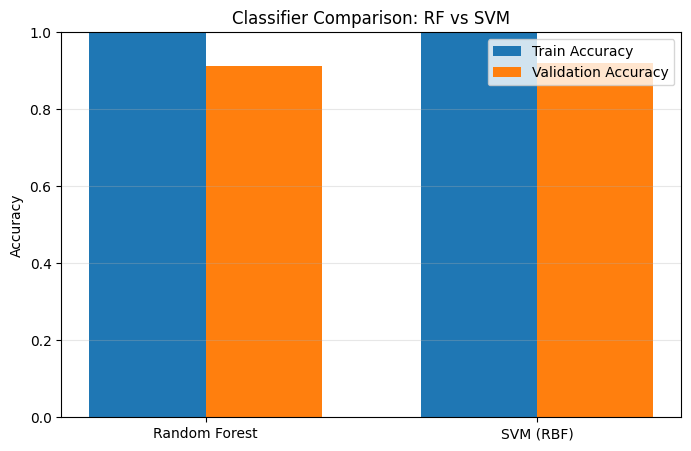


Random Forest: 
Train accuracy: 100.0 Validation accuracy: 91.33489461358315
--------------------------------------------------
SVM: 
Train accuracy: 99.91215226939971 Validation accuracy: 91.92037470725995


In [ ]:
# Paths to saved results
rf_path = f'{PROJECT_ROOT}/models/classifier/classification_results.json'
svm_path = f'{PROJECT_ROOT}/models/classifier/classification_results_svm.json'

# Load results
with open(rf_path) as f:
    rf_results = json.load(f)

with open(svm_path) as f:
    svm_results = json.load(f)

models = ['Random Forest', 'SVM (RBF)']
train_acc = [
    rf_results['train_accuracy'],
    svm_results['train_accuracy']
]
val_acc = [
    rf_results['validation_accuracy'],
    svm_results['validation_accuracy']
]

# Plot
x = range(len(models))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x, train_acc, width, label='Train Accuracy')
plt.bar([i + width for i in x], val_acc, width, label='Validation Accuracy')

plt.xticks([i + width/2 for i in x], models)
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Classifier Comparison: RF vs SVM')
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Save
os.makedirs(f'{PROJECT_ROOT}/results/classification', exist_ok=True)
plt.savefig(f'{PROJECT_ROOT}/results/classification/rf_vs_svm_accuracy.png',
            dpi=150, bbox_inches='tight')

plt.show()
print("\nRandom Forest: \nTrain accuracy:",rf_results['train_accuracy']*100, "Validation accuracy:",rf_results['validation_accuracy']*100)
print("-"*50)
print("SVM: \nTrain accuracy:",svm_results['train_accuracy']*100, "Validation accuracy:",svm_results['validation_accuracy']*100)

# Confusion Matrix

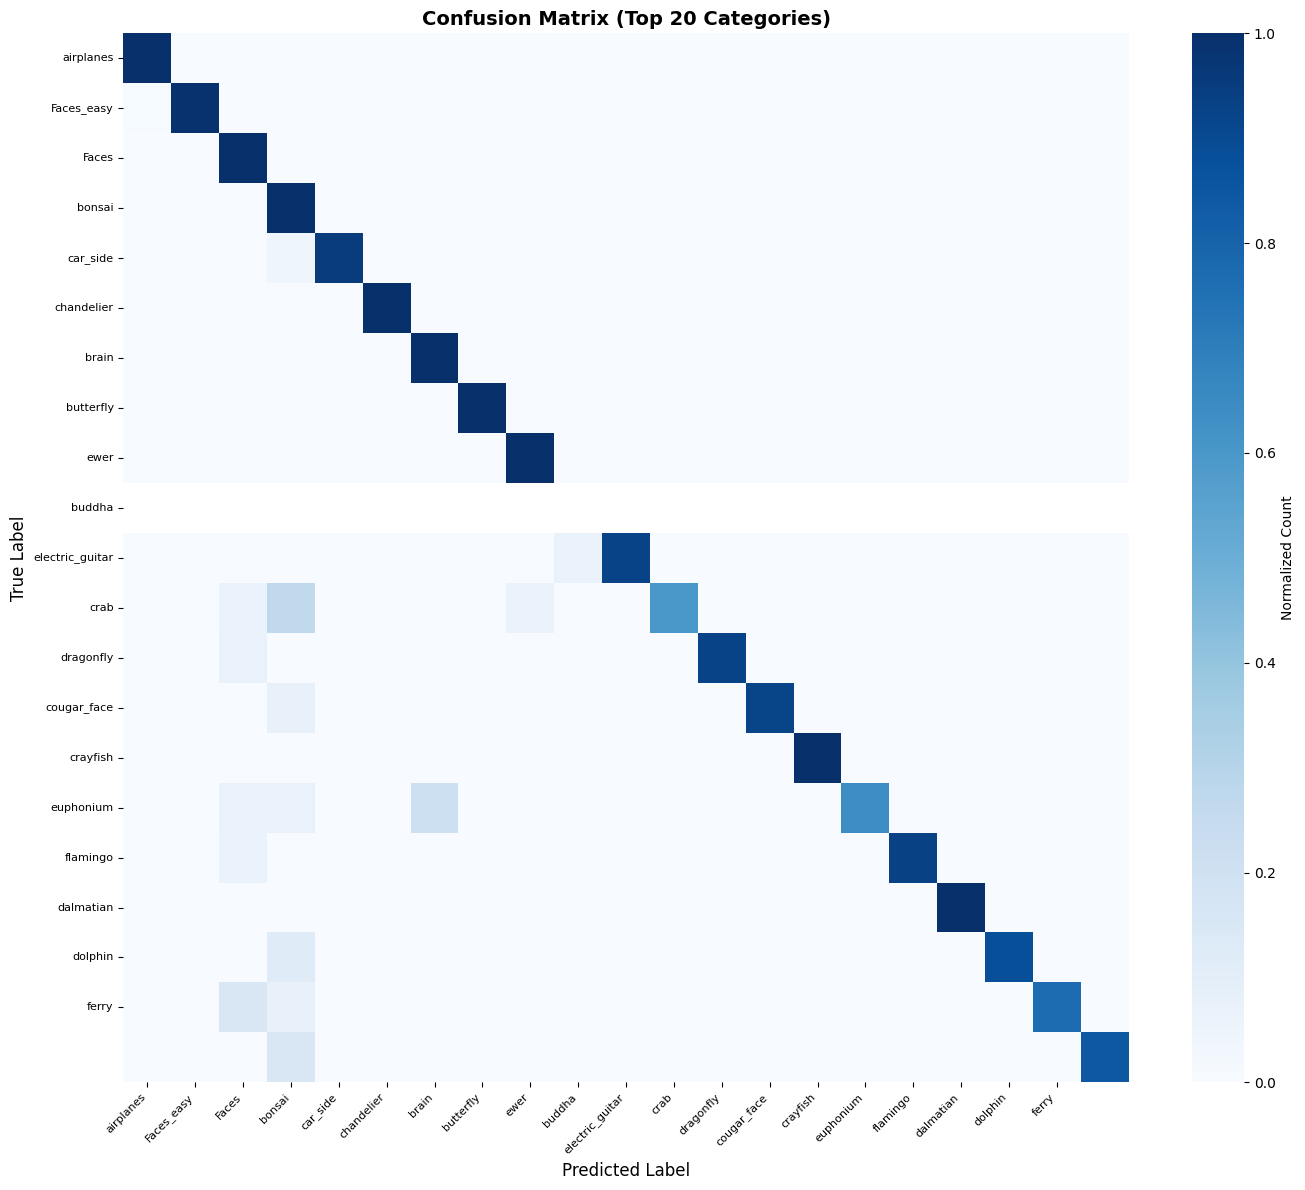

✅ Confusion matrix saved!


In [ ]:
def plot_confusion_matrix(y_true, y_pred, categories, top_n=20):
    """Plot confusion matrix for top N categories"""
    # Top N frequent categories
    unique, counts = np.unique(y_true, return_counts=True)
    top_indices = np.argsort(counts)[::-1][:top_n]

    mask = np.isin(y_true, top_indices)
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]

    cm = confusion_matrix(y_true_filtered, y_pred_filtered)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    category_names = [categories[i] for i in top_indices]

    plt.figure(figsize=(14, 12))
    sns.heatmap(cm_norm, annot=False, fmt='.2f', cmap='Blues',xticklabels=category_names, yticklabels=category_names,cbar_kws={'label': 'Normalized Count'})
    plt.title(f'Confusion Matrix (Top {top_n} Categories)', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()

    # Save
    os.makedirs(f'{PROJECT_ROOT}/results/classification', exist_ok=True)
    plt.savefig(f'{PROJECT_ROOT}/results/classification/confusion_matrix.png',
                dpi=150, bbox_inches='tight')
    plt.show()

    print("✅ Confusion matrix saved!")

# Plot confusion matrix for validation set using SVM predictions
plot_confusion_matrix(y_val_split, val_pred_svm, full_dataset.categories, top_n=20)


# PHASE 5: FINAL EVALUATION
## Generate Comprehensive Report

In [ ]:
print("-"*60)
print("PHASE 5: FINAL EVALUATION")
print("-"*60)

def generate_final_report():
    """Generate comprehensive report combining clustering, retrieval, classification"""
    print("\n📝 Generating final report...")

    # --- Load clustering metrics (Hierarchical) ---
    clustering_metrics_path = f'{PROJECT_ROOT}/models/clustering/hir_metrics_k50.json' # Corrected path
    if os.path.exists(clustering_metrics_path):
        with open(clustering_metrics_path) as f:
            clustering_metrics = json.load(f)
    else:
        # Fallback if the file still doesn't exist, though it should now
        print(f"Warning: Clustering metrics file not found at {clustering_metrics_path}. Using default values.")
        clustering_metrics = {
            'k': 50, # Changed n_clusters to k to match saved metric key
            'silhouette_score': 0,
            'davies_bouldin_score': 0,
            'cluster_sizes': {}
        }

    # --- Load retrieval metrics ---
    retrieval_metrics_path = f'{PROJECT_ROOT}/results/retrieval/retrieval_metrics.json'
    if os.path.exists(retrieval_metrics_path):
        with open(retrieval_metrics_path) as f:
            retrieval_metrics = json.load(f)
    else:
        retrieval_metrics = {}

    # --- Load classification metrics (SVM) ---
    classification_results_path = f'{PROJECT_ROOT}/models/classifier/classification_results_svm.json'
    if os.path.exists(classification_results_path):
        with open(classification_results_path) as f:
            classification_results = json.load(f)
    else:
        classification_results = {
            'classifier_type': 'SVM',
            'train_accuracy': 0,
            'validation_accuracy': 0
        }

    # --- Load dataset metadata ---
    dataset_metadata_path = f'{PROJECT_ROOT}/configs/dataset_metadata.json'
    if os.path.exists(dataset_metadata_path):
        with open(dataset_metadata_path) as f:
            dataset_info = json.load(f)
    else:
        dataset_info = {
            'num_categories': len(full_dataset.categories),
            'num_images': len(full_dataset.image_paths),
            'categories': full_dataset.categories
        }

    # --- Compose report ---
    report = {
        'dataset': dataset_info,
        'feature_extraction': {
            'model': 'ResNet-50',
            'feature_dim': 2048,
            'preprocessing': 'L2 normalization'
        },
        'clustering': clustering_metrics,
        'retrieval': retrieval_metrics,
        'classification': classification_results,
        'generated_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }

    # --- Save report ---
    save_path = f'{PROJECT_ROOT}/results/final_report.json'
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    with open(save_path, 'w') as f:
        json.dump(report, f, indent=2)

    # --- Print summary ---
    print("\n" + "="*60)
    print("FINAL SYSTEM SUMMARY")
    print("="*60)
    print(f"\n📊 Dataset: Caltech-101")
    print(f"   Total categories: {dataset_info['num_categories']}")
    print(f"   Total images: {dataset_info['num_images']}")
    print(f"\n🔧 Feature Extractor: ResNet-50 (2048-dim)")
    print(f"\n🎯 Clustering (Hierarchical):")
    print(f"   • Number of clusters: {clustering_metrics.get('k', 'N/A')}") # Changed n_clusters to k
    print(f"   • Silhouette Score: {clustering_metrics.get('silhouette_score', 0):.4f}")
    print(f"   • Davies-Bouldin: {clustering_metrics.get('davies_bouldin_score', 0):.4f}")
    print(f"\n🔍 Retrieval:")
    print(f"   • Precision@10: {retrieval_metrics.get('precision@10', 'N/A')}")
    print(f"   • Index size: {getattr(retrieval.index, 'ntotal', 'N/A')} vectors")
    print(f"\n🎓 Classification (SVM):")
    print(f"   • Model: {classification_results.get('classifier_type', 'SVM')}")
    print(f"   • Training Accuracy: {classification_results.get('train_accuracy', 0):.4f}")
    print(f"   • Validation Accuracy: {classification_results.get('validation_accuracy', 0):.4f}")
    print("="*60)

    print("\n✅ Final report generated!")
    return report

# Run
final_report = generate_final_report()


------------------------------------------------------------
PHASE 5: FINAL EVALUATION
------------------------------------------------------------

📝 Generating final report...

FINAL SYSTEM SUMMARY

📊 Dataset: Caltech-101
   Total categories: 45
   Total images: 4269

🔧 Feature Extractor: ResNet-50 (2048-dim)

🎯 Clustering (Hierarchical):
   • Number of clusters: 50
   • Silhouette Score: 0.1981
   • Davies-Bouldin: 2.1370

🔍 Retrieval:
   • Precision@10: 0.9936753338018272
   • Index size: 4269 vectors

🎓 Classification (SVM):
   • Model: svm_rbf
   • Training Accuracy: 0.9991
   • Validation Accuracy: 0.9192

✅ Final report generated!


# Performance Summary Visualization

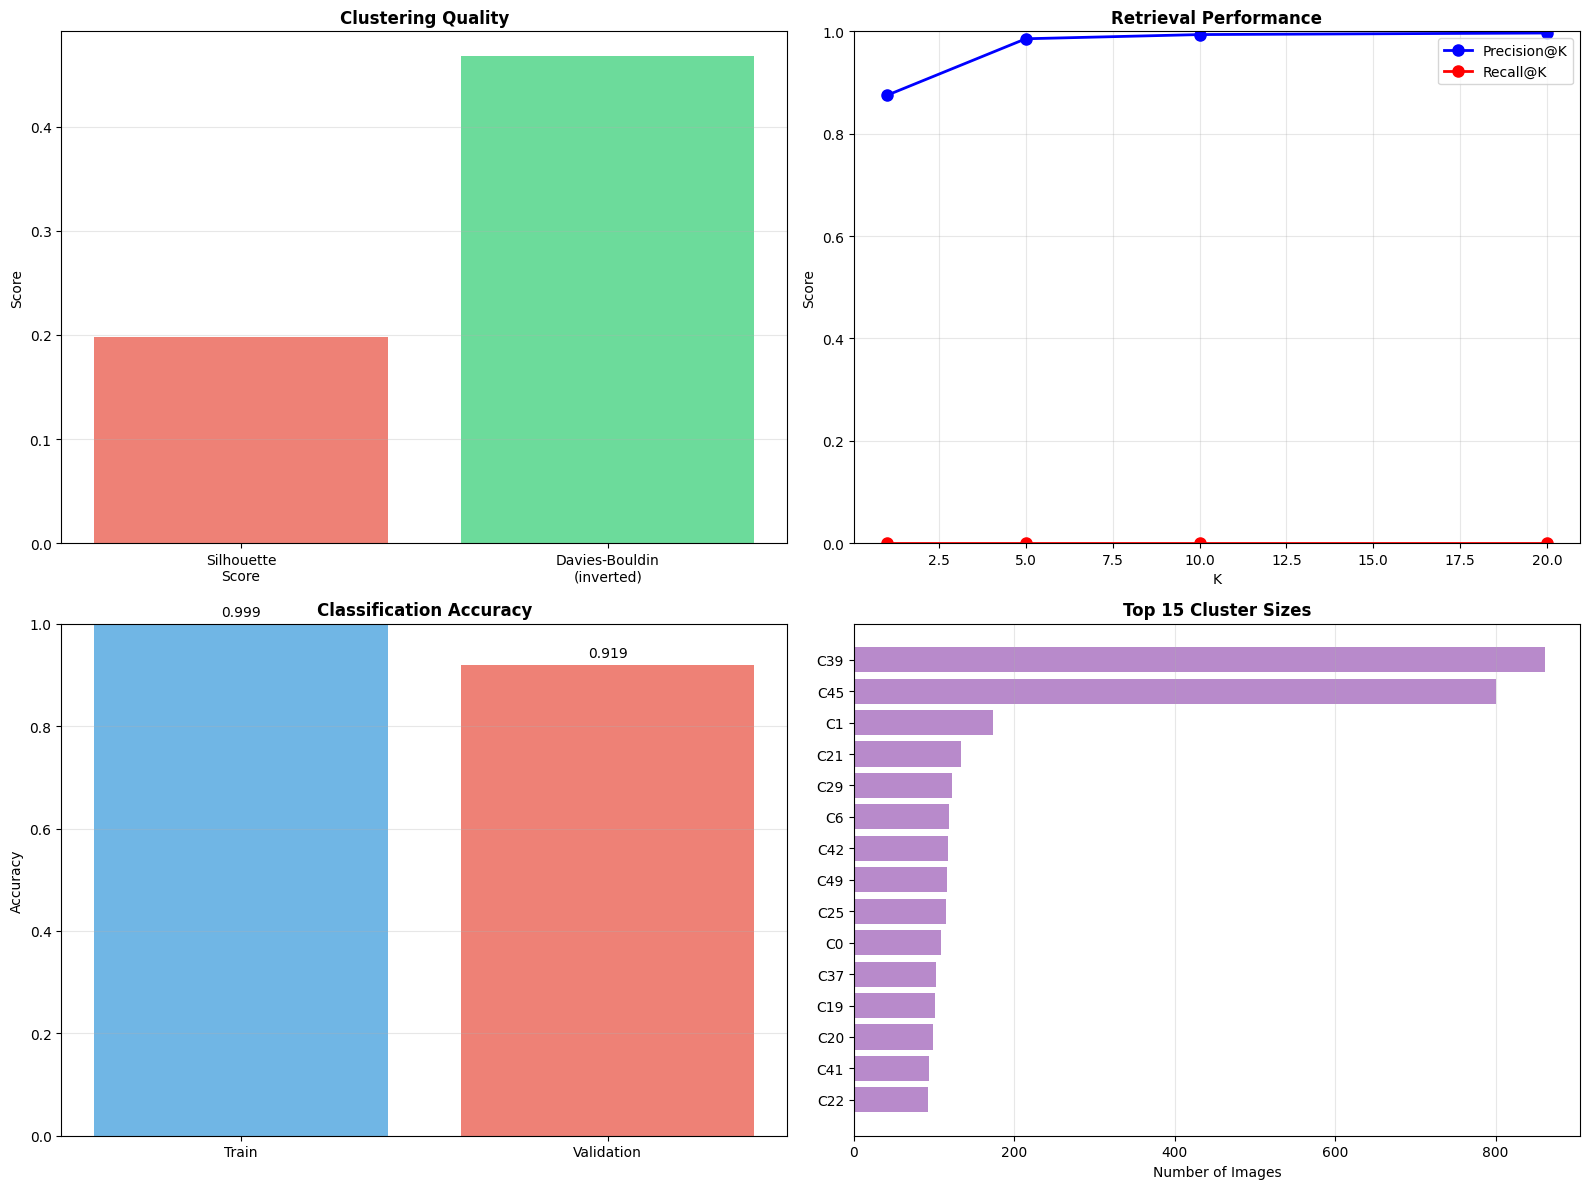

✅ Performance summary saved!


In [ ]:
def plot_performance_summary(report):
    """Create an enhanced performance summary visualization (without entropy plot)"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    # 1️⃣ Clustering Quality
    ax = axes[0, 0]
    metrics_values = [
        report['clustering'].get('silhouette_score', 0),
        1 / report['clustering'].get('davies_bouldin_score', 1e-5)  # invert DB
    ]
    metrics_names = ['Silhouette\nScore', 'Davies-Bouldin\n(inverted)']
    colors = ['#2ecc71' if v > 0.3 else '#e74c3c' for v in metrics_values]
    ax.bar(metrics_names, metrics_values, color=colors, alpha=0.7)
    ax.set_ylabel('Score')
    ax.set_title('Clustering Quality', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

    # 2️⃣ Retrieval Performance
    ax = axes[0, 1]
    k_values = [1, 5, 10, 20]
    precisions = [report['retrieval'].get(f'precision@{k}', 0) for k in k_values]
    recalls = [report['retrieval'].get(f'recall@{k}', 0) for k in k_values]
    ax.plot(k_values, precisions, 'bo-', linewidth=2, markersize=8, label='Precision@K')
    ax.plot(k_values, recalls, 'ro-', linewidth=2, markersize=8, label='Recall@K')
    ax.set_xlabel('K')
    ax.set_ylabel('Score')
    ax.set_title('Retrieval Performance', fontsize=12, fontweight='bold')
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)
    ax.legend()

    # 3️⃣ Classification Accuracy
    ax = axes[1, 0]
    accuracies = [
        report['classification'].get('train_accuracy', 0),
        report['classification'].get('validation_accuracy', 0)
    ]
    labels = ['Train', 'Validation']
    colors_acc = ['#3498db', '#e74c3c']
    bars = ax.bar(labels, accuracies, color=colors_acc, alpha=0.7)
    ax.set_ylabel('Accuracy')
    ax.set_title('Classification Accuracy', fontsize=12, fontweight='bold')
    ax.set_ylim(0, 1)
    ax.grid(axis='y', alpha=0.3)
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10)

    # 4️⃣ Top Cluster Sizes
    ax = axes[1, 1]
    cluster_sizes = report['clustering'].get('cluster_sizes', {})
    top_clusters = sorted(cluster_sizes.items(), key=lambda x: x[1], reverse=True)[:15]
    cluster_ids = [f"C{k}" for k, _ in top_clusters]
    sizes = [v for _, v in top_clusters]
    ax.barh(cluster_ids[::-1], sizes[::-1], color='#9b59b6', alpha=0.7)
    ax.set_xlabel('Number of Images')
    ax.set_title('Top 15 Cluster Sizes', fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    os.makedirs(f'{PROJECT_ROOT}/results', exist_ok=True)
    plt.savefig(f'{PROJECT_ROOT}/results/performance_summary.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("✅ Performance summary saved!")

# Example usage
plot_performance_summary(final_report)